In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../../src")
import model.util as model_util
import model.cnn as cnn
import model.mechint_net as mechint_net
import feature.simulated_dataset as simulated_dataset
import feature.util as feature_util
import train.train_model as train_model
import train.performance as performance
import analysis.motif_util as motif_util
import analysis.motif_compare as motif_compare
import plot.plot_motifs as plot_motifs
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import tqdm.notebook

In [2]:
# Plotting defaults
font_files = font_manager.findSystemFonts(fontpaths="/home/tsenga5/lib/fonts")
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

In [3]:
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define constants and paths

In [4]:
base_path = "/projects/site/gred/resbioai/tsenga5/mechint_regnet/"

In [5]:
motif_config_path = os.path.join(base_path, "data/simulations/configs/spi1_sanit_single_config.json")
neg_motif_config_path = None

In [6]:
losstune_model_base = os.path.join(base_path, "models/trained_models/simulated/spi1_exp_single/standard_cnn_with_sparsereg_lossweighttune")

### Examine performance with respect to loss weight
And identify best-performing loss weight

In [7]:
loss_weight_results = {}  # run : (loss weight, test accuracy, sparsity loss value)
for run_num in os.listdir(losstune_model_base):
    if not run_num.isnumeric():
        continue
        
    metrics_path = os.path.join(losstune_model_base, run_num, "metrics.json")
    config_path = os.path.join(losstune_model_base, run_num, "config.json")

    with open(metrics_path, "r") as f:
        metrics = json.load(f)
        test_acc = metrics["test_acc"]["values"][0]
        sparsity_loss_val = metrics["val_epoch_loss_conv_act_l1"]["values"][-1]
    with open(config_path, "r") as f:
        config = json.load(f)
        loss_weight = config["cnn_model"]["conv_act_l1_loss_weight"]

    loss_weight_results[run_num] = (loss_weight, test_acc, sparsity_loss_val)

/tmp/ipykernel_1167743/3591291082.py:7: RuntimeWarning: divide by zero encountered in log10
  ax[1].scatter(np.log10(loss_weights), np.log10(sparsity_loss_vals))


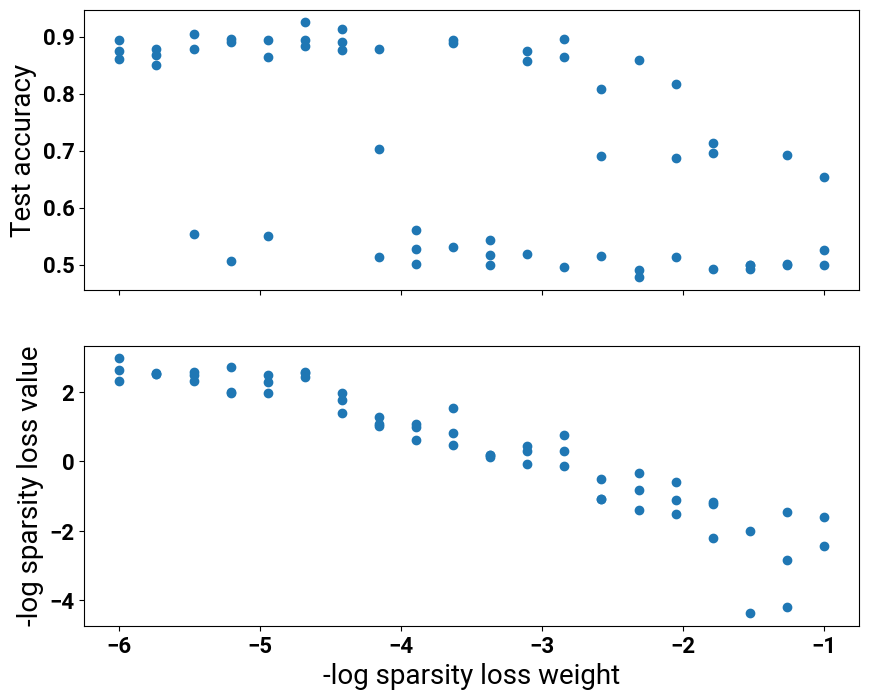

In [8]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10, 8))
keys = np.array(list(loss_weight_results.keys()))
loss_weights = np.array([loss_weight_results[key][0] for key in keys])
test_accs = np.array([loss_weight_results[key][1] for key in keys])
sparsity_loss_vals = np.array([loss_weight_results[key][2] for key in keys])
ax[0].scatter(np.log10(loss_weights), test_accs)
ax[1].scatter(np.log10(loss_weights), np.log10(sparsity_loss_vals))
ax[0].set_ylabel("Test accuracy")
ax[1].set_ylabel("log sparsity loss value")
ax[1].set_xlabel("log sparsity loss weight")
plt.show()

In [9]:
# Pick the best model runs
passing_inds = np.where((test_accs > 0.85) & (sparsity_loss_vals < 1e1))[0]
print(loss_weights[passing_inds])
passing_runs = keys[passing_inds]
print(passing_runs)

[0.00078476 0.00143845 0.00023357 0.00078476 0.00143845 0.00483293]
['34' '39' '29' '35' '38' '44']


### Examine motifs of passing runs and quantify interpretability

In [10]:
def model_to_pfms(model, data_loader, max_thresh_frac=0.5):
    """
    Given a model and a data loader, runs through the input sequences
    in the data loader and collects convolutional activations from the
    entire epoch.
    Returns a F x W x 4 array of PFMs for the filters. If a filter is
    never activated, its PFM will be all 0.
    """
    _, _, _, _, model_outputs_other, input_data = \
        train_model.run_epoch(data_loader, "eval", model, epoch_num=0, return_extras=True)
    conv_acts = model_outputs_other["conv_acts"]  # Shape: N x L' x F
    input_seqs = input_data[0]  # Shape: N x L x 4
    num_filters = conv_acts.shape[2]
    filter_width = input_seqs.shape[1] - conv_acts.shape[1] + 1

    # Compute minimum activations needed
    act_threshes = np.max(conv_acts, axis=(0, 1)) * max_thresh_frac

    # Construct PFMs
    pfms = np.zeros((num_filters, filter_width, 4))
    for i in range(num_filters):
        if act_threshes[i] == 0:
            continue
        ex_inds, start_inds = np.where(conv_acts[:, :, i] > act_threshes[i])
        if not ex_inds.size:
            # Nothing passed the threshold
            continue
        # Trick to get all matching subsequences, where we flatten the set of all
        # indices we want and then reshape
        seqs = input_seqs[
            np.repeat(ex_inds, filter_width),
            (np.arange(filter_width)[None] + start_inds[:, None]).reshape(-1)
        ].reshape(len(ex_inds), filter_width, -1)
        pfms[i] = np.mean(seqs, axis=0)

    return pfms

In [11]:
data_loader = simulated_dataset.dataset_ex.run(
    "create_data_loader", config_updates={
        "motif_config_path": motif_config_path,
        "input_length": 500,
        "motif_center_dist_bound": 50,
        "batch_size": 128,
        "num_batches": 10,
        "background_match_reject_prob": 1,
        "neg_motif_config_path": neg_motif_config_path
    }
).result

WARNING - root - Added new config entry: "motif_config_path"
WARNING - root - Added new config entry: "neg_motif_config_path"
WARNING - sim_dataset - No observers have been added to this run
INFO - sim_dataset - Running command 'create_data_loader'
INFO - sim_dataset - Started
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO - sim_dataset - Result: <torch.utils.data.dataloader.DataLoader object at 0x1540564a9310>
INFO - sim_dataset - Completed after 0:00:00


In [12]:
# Import set of true motifs
with open(motif_config_path, "r") as f:
    motif_config = json.load(f)
    motif_files = motif_config["motif_files"]
true_pfms = {}
for motif_file in motif_files:
    true_pfms.update({
        key : val for key, val in motif_util.import_meme_motifs(motif_file).items()
        if key.endswith("_exp")
    })

	Loss: 0.1286: 100%|████████████████████████████████████████| 10/10 [00:02<00:00,  4.45it/s]
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])


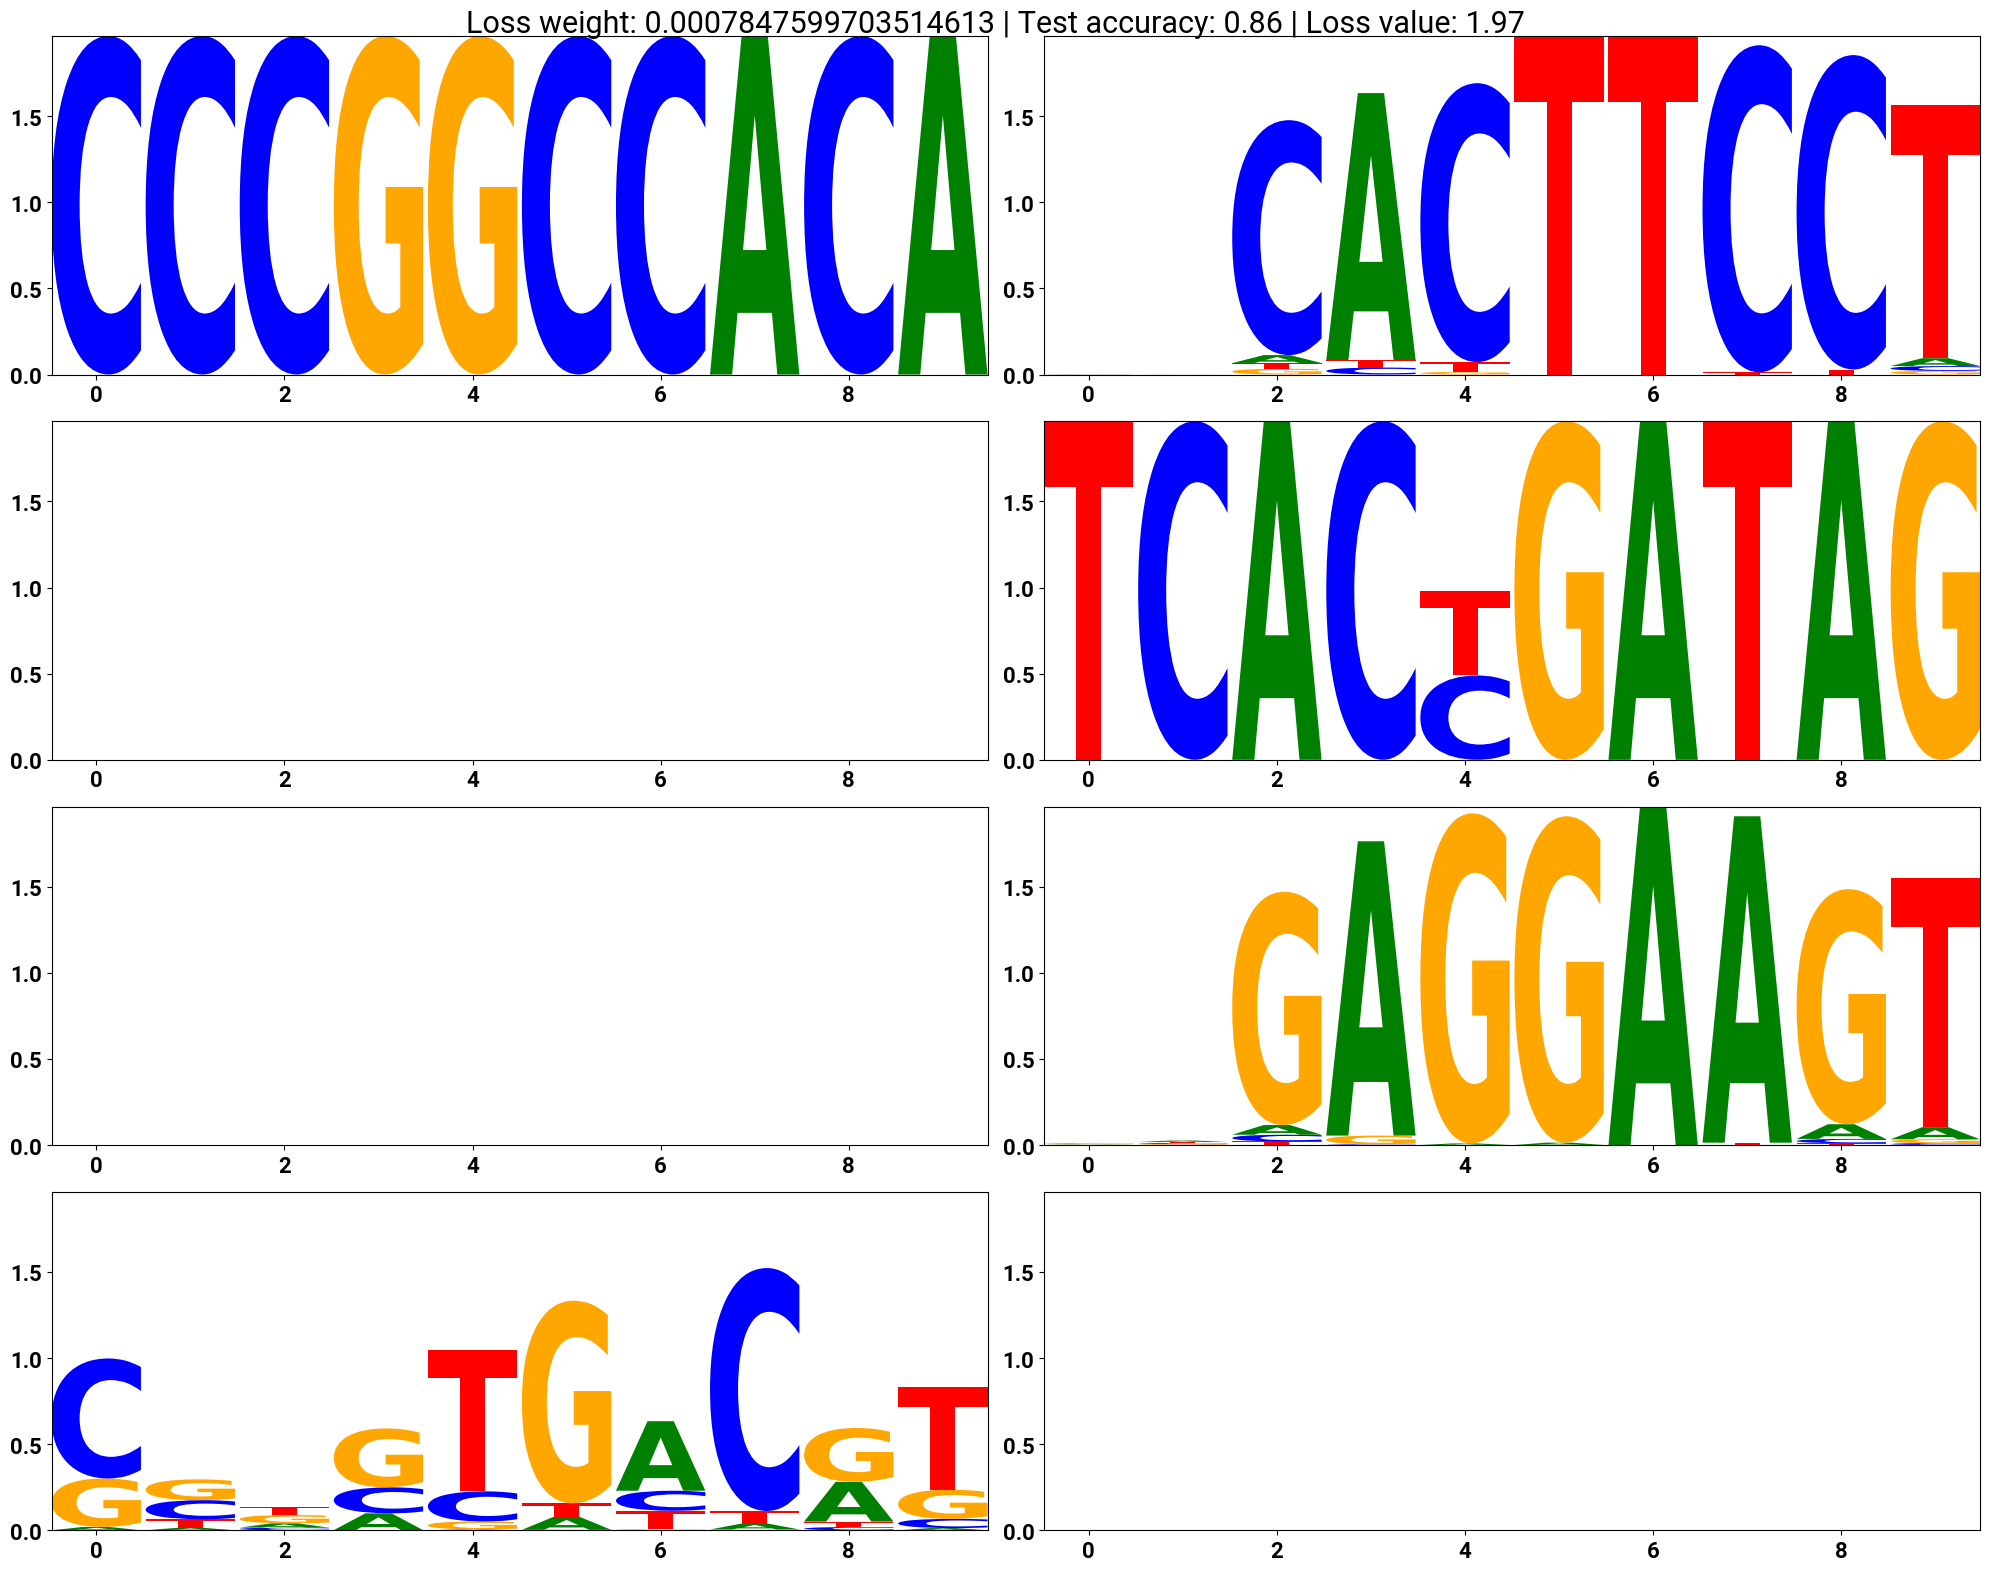

Intepretability score: 2.04


/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
	Loss: 0.1279: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 21.19it/s]


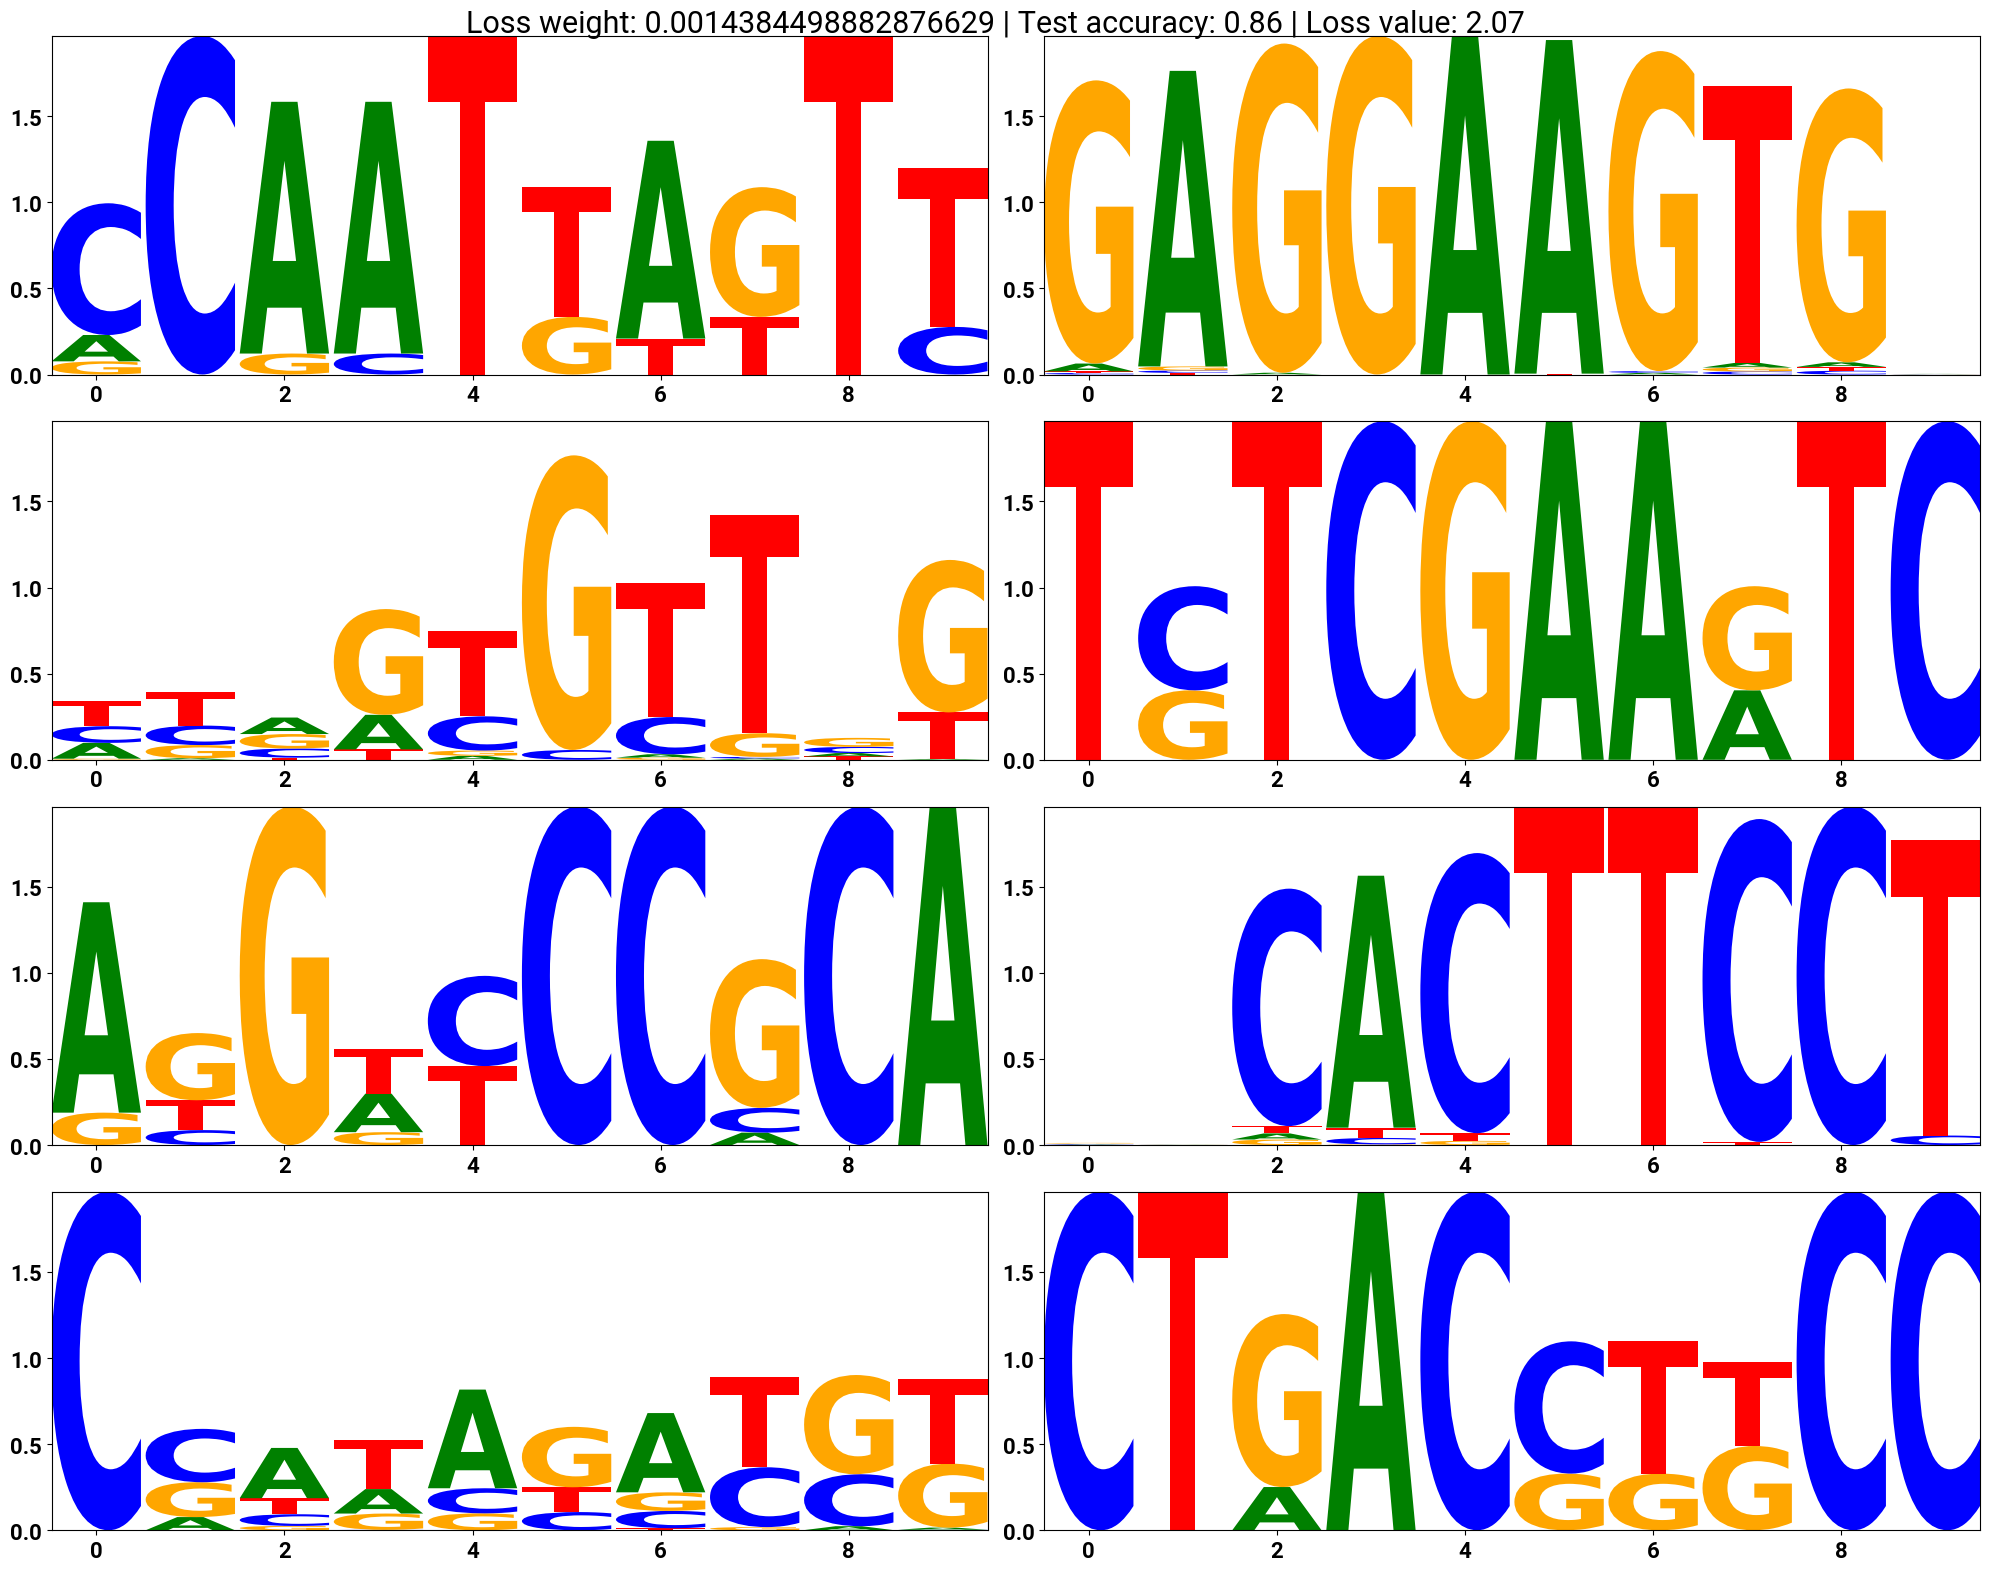

Intepretability score: 1.35


/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
	Loss: 0.1638: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 17.44it/s]


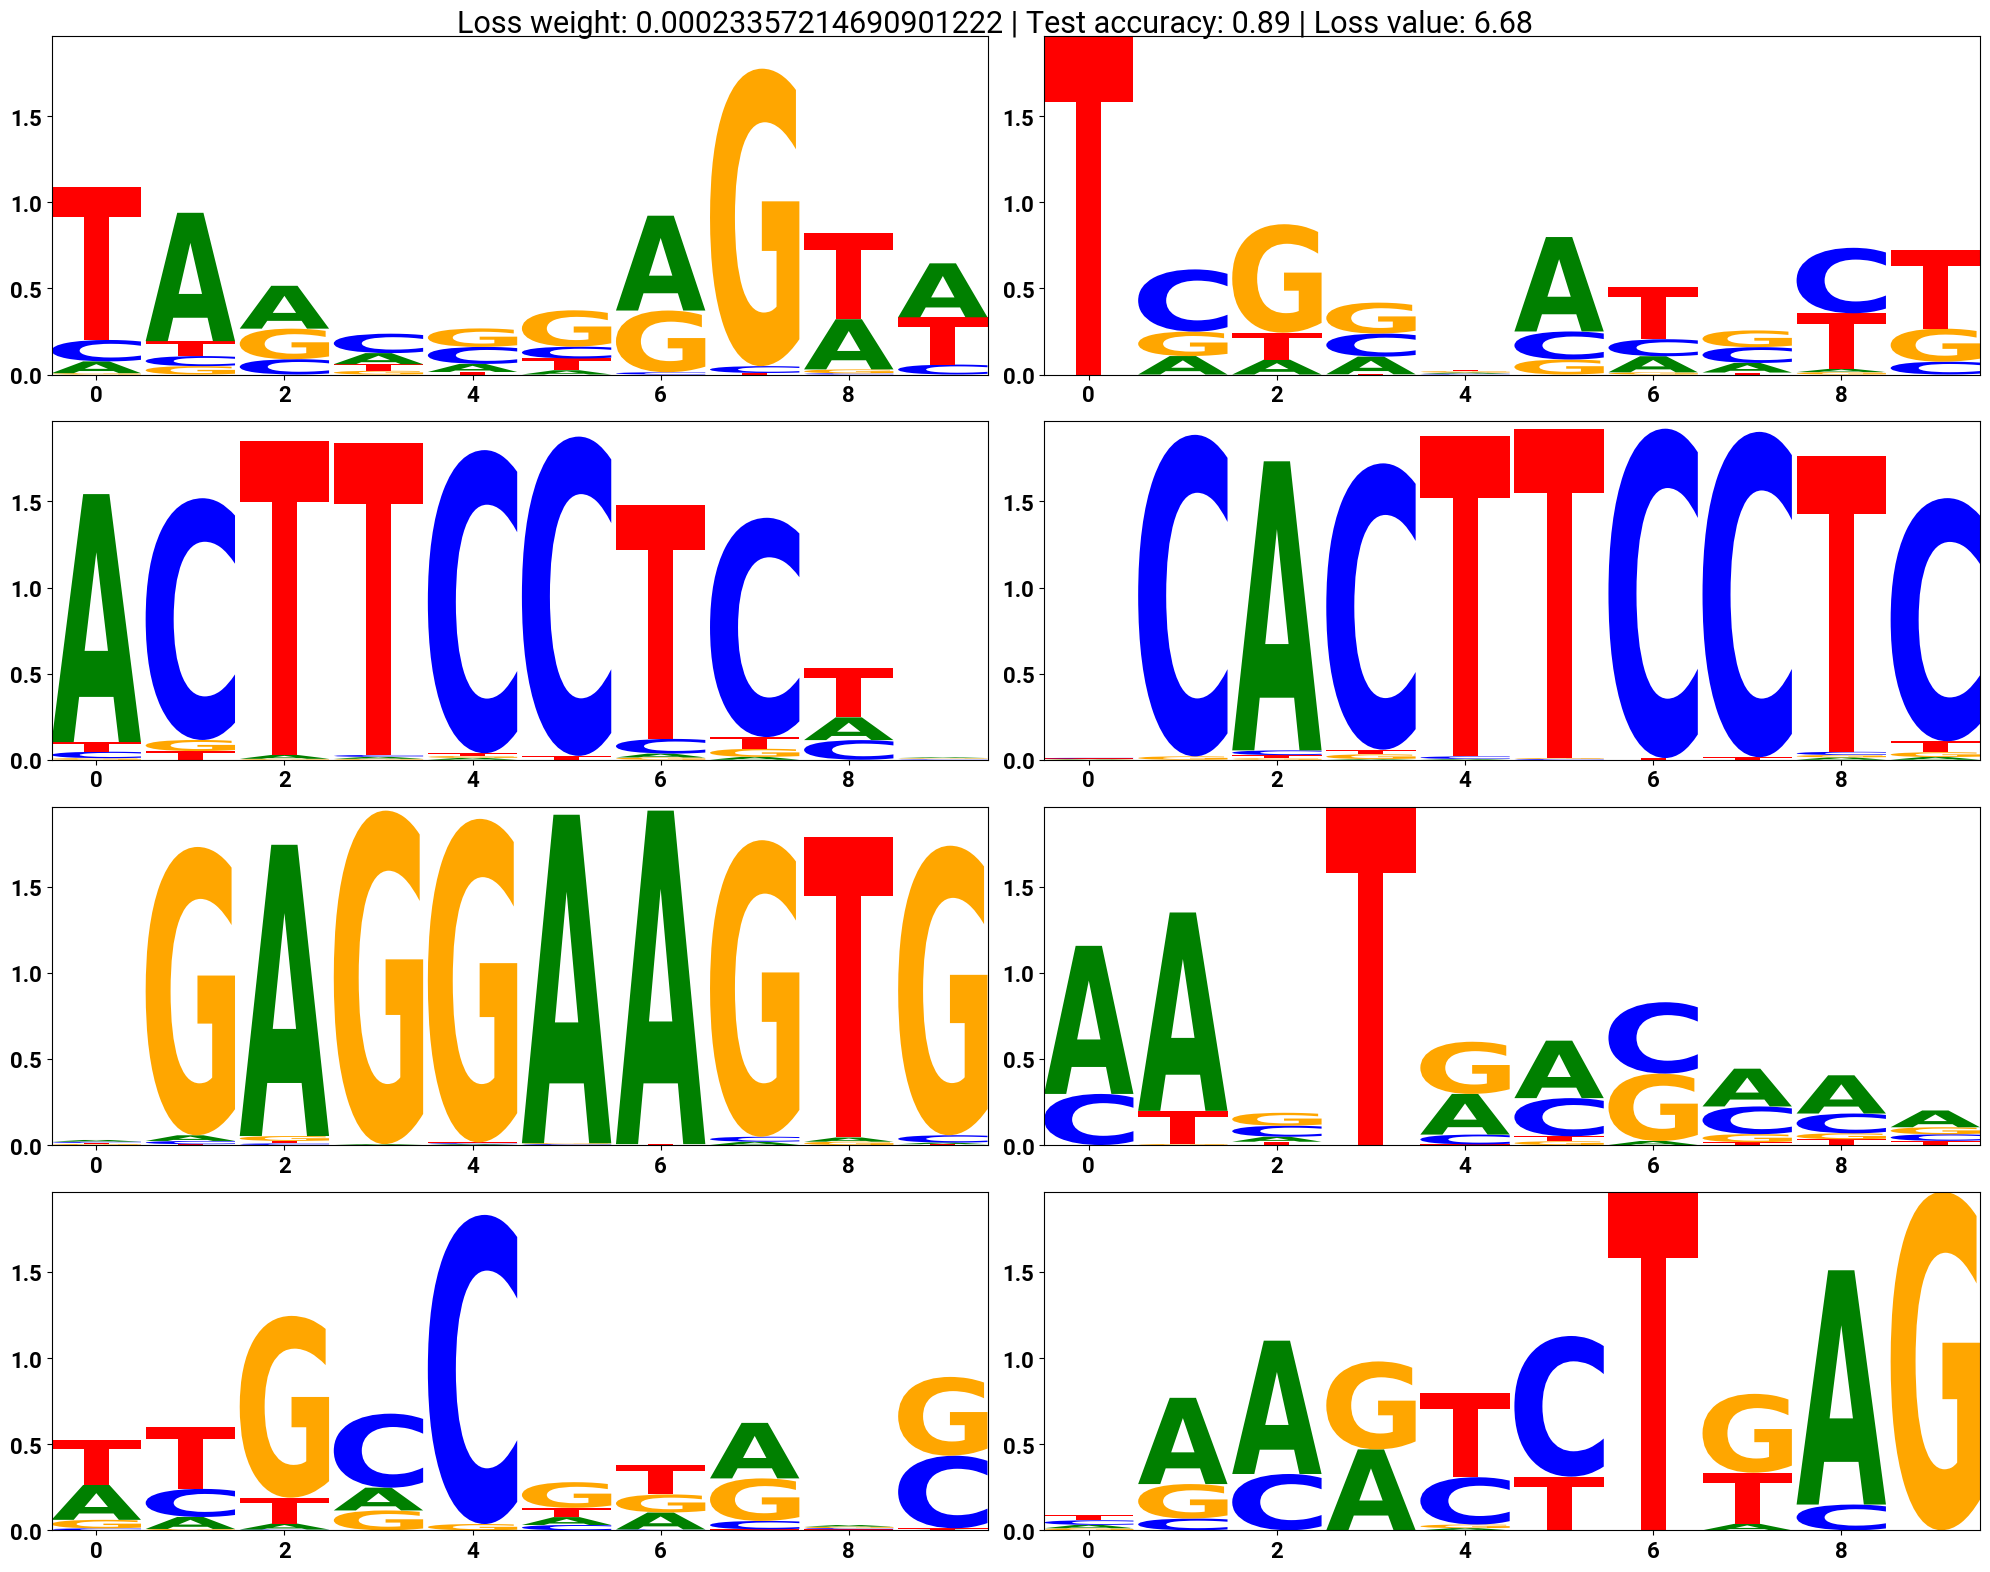

Intepretability score: 2.19


/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
	Loss: 0.1424: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 18.14it/s]


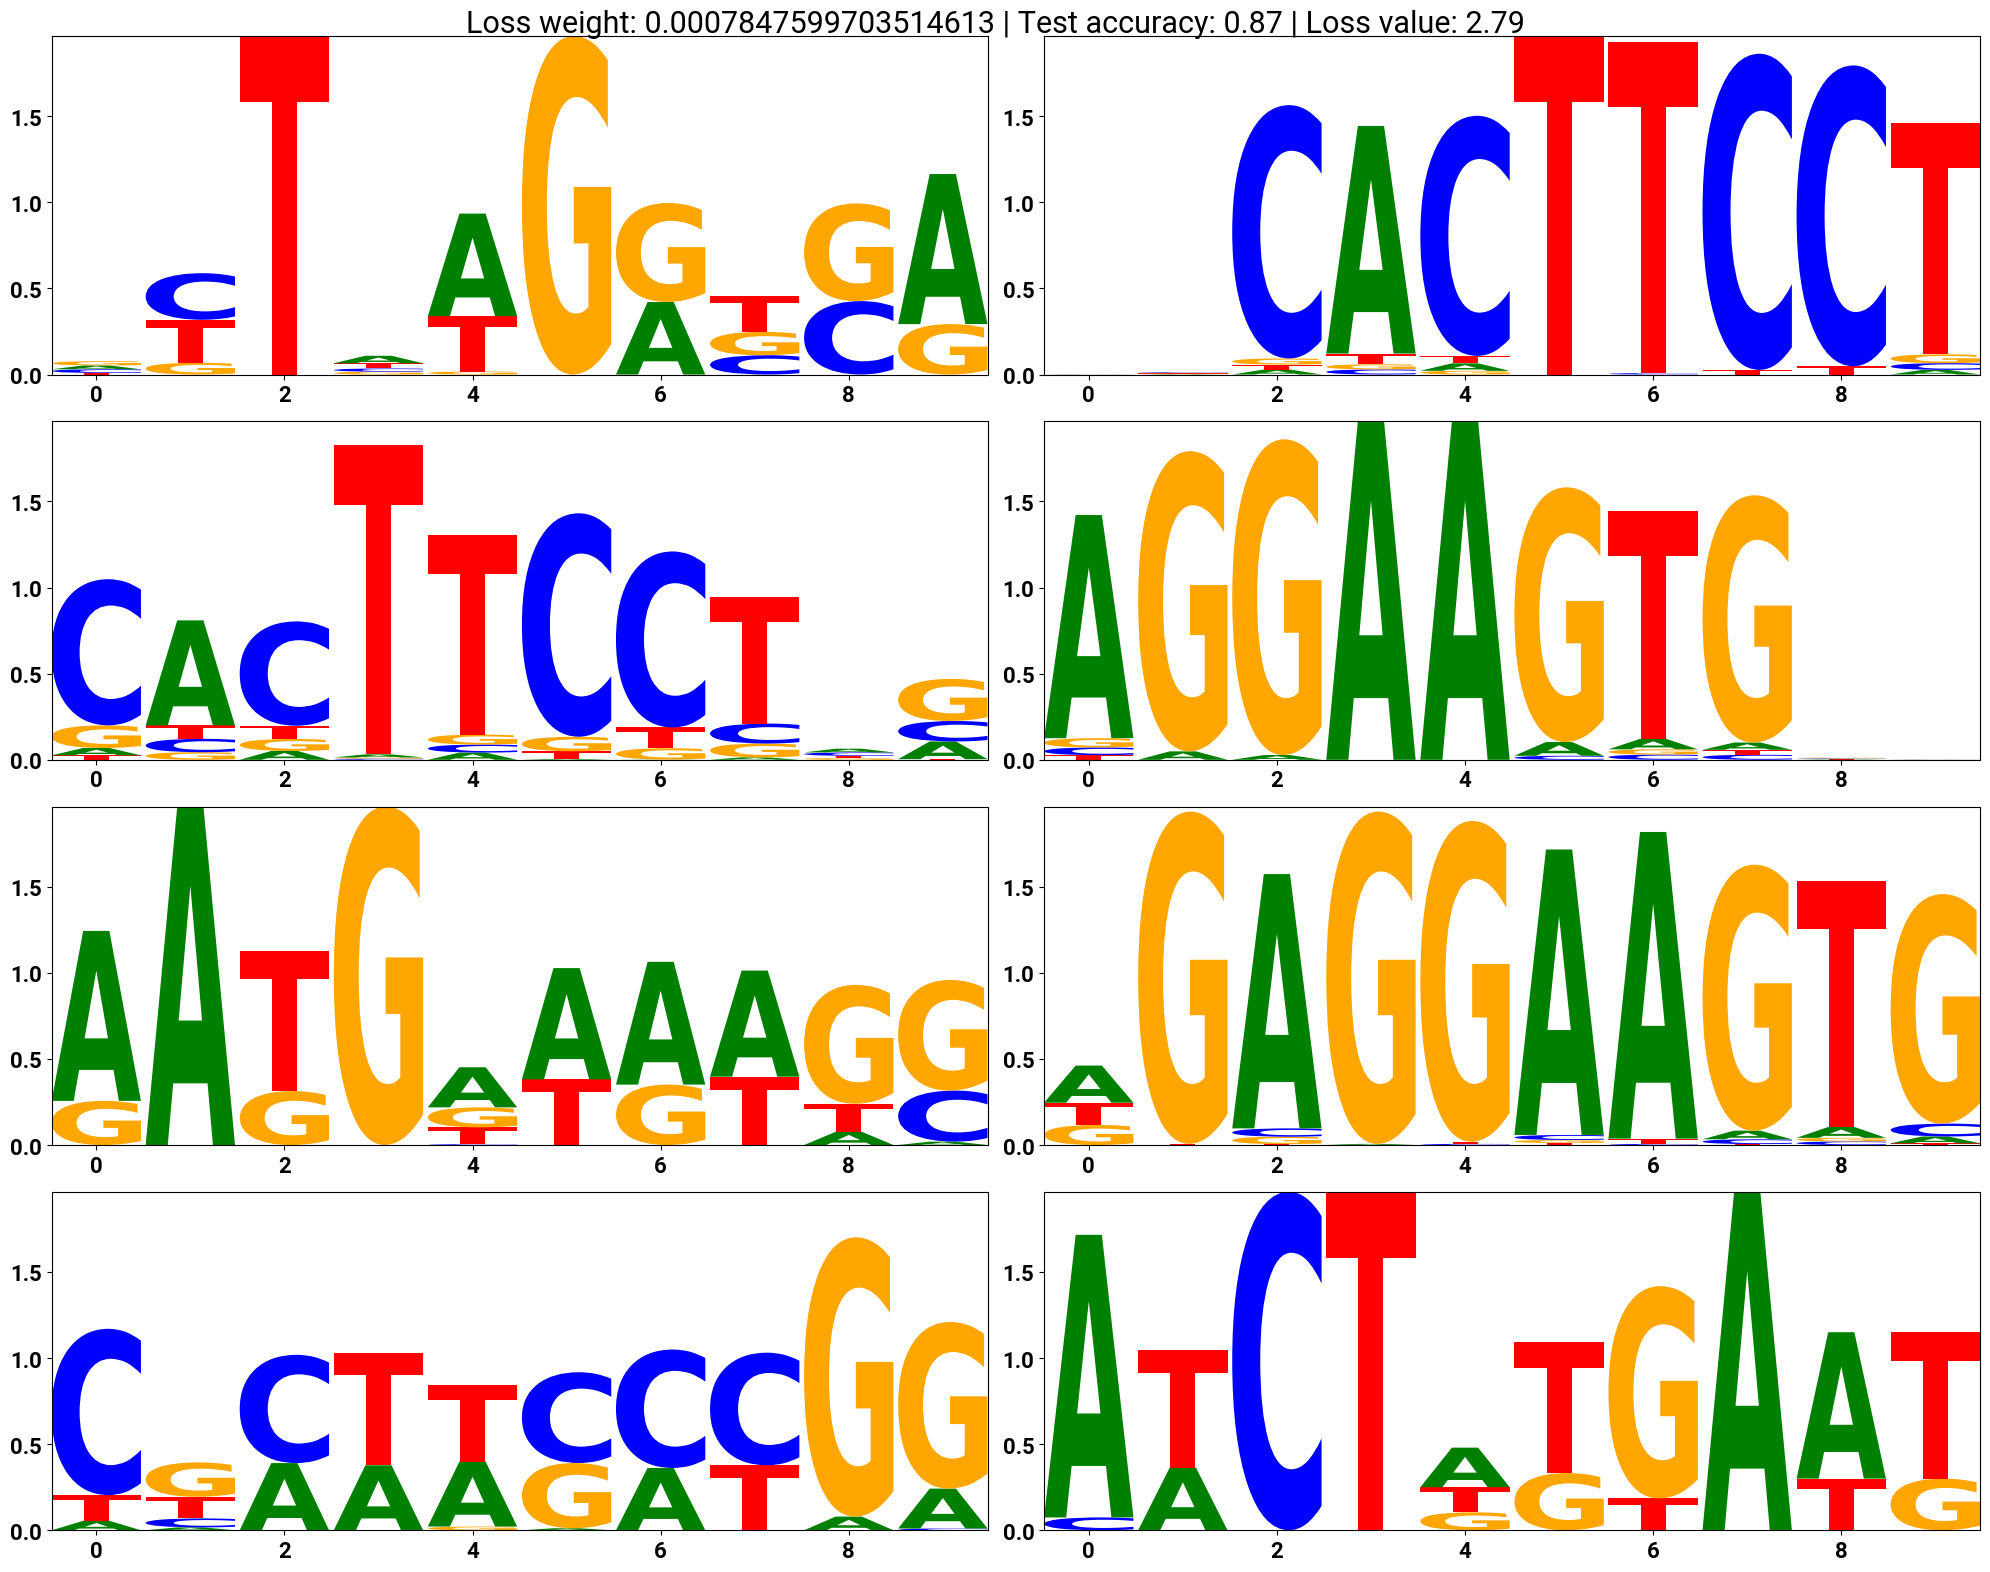

Intepretability score: 2.81


/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
	Loss: 0.1942: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 16.50it/s]
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])


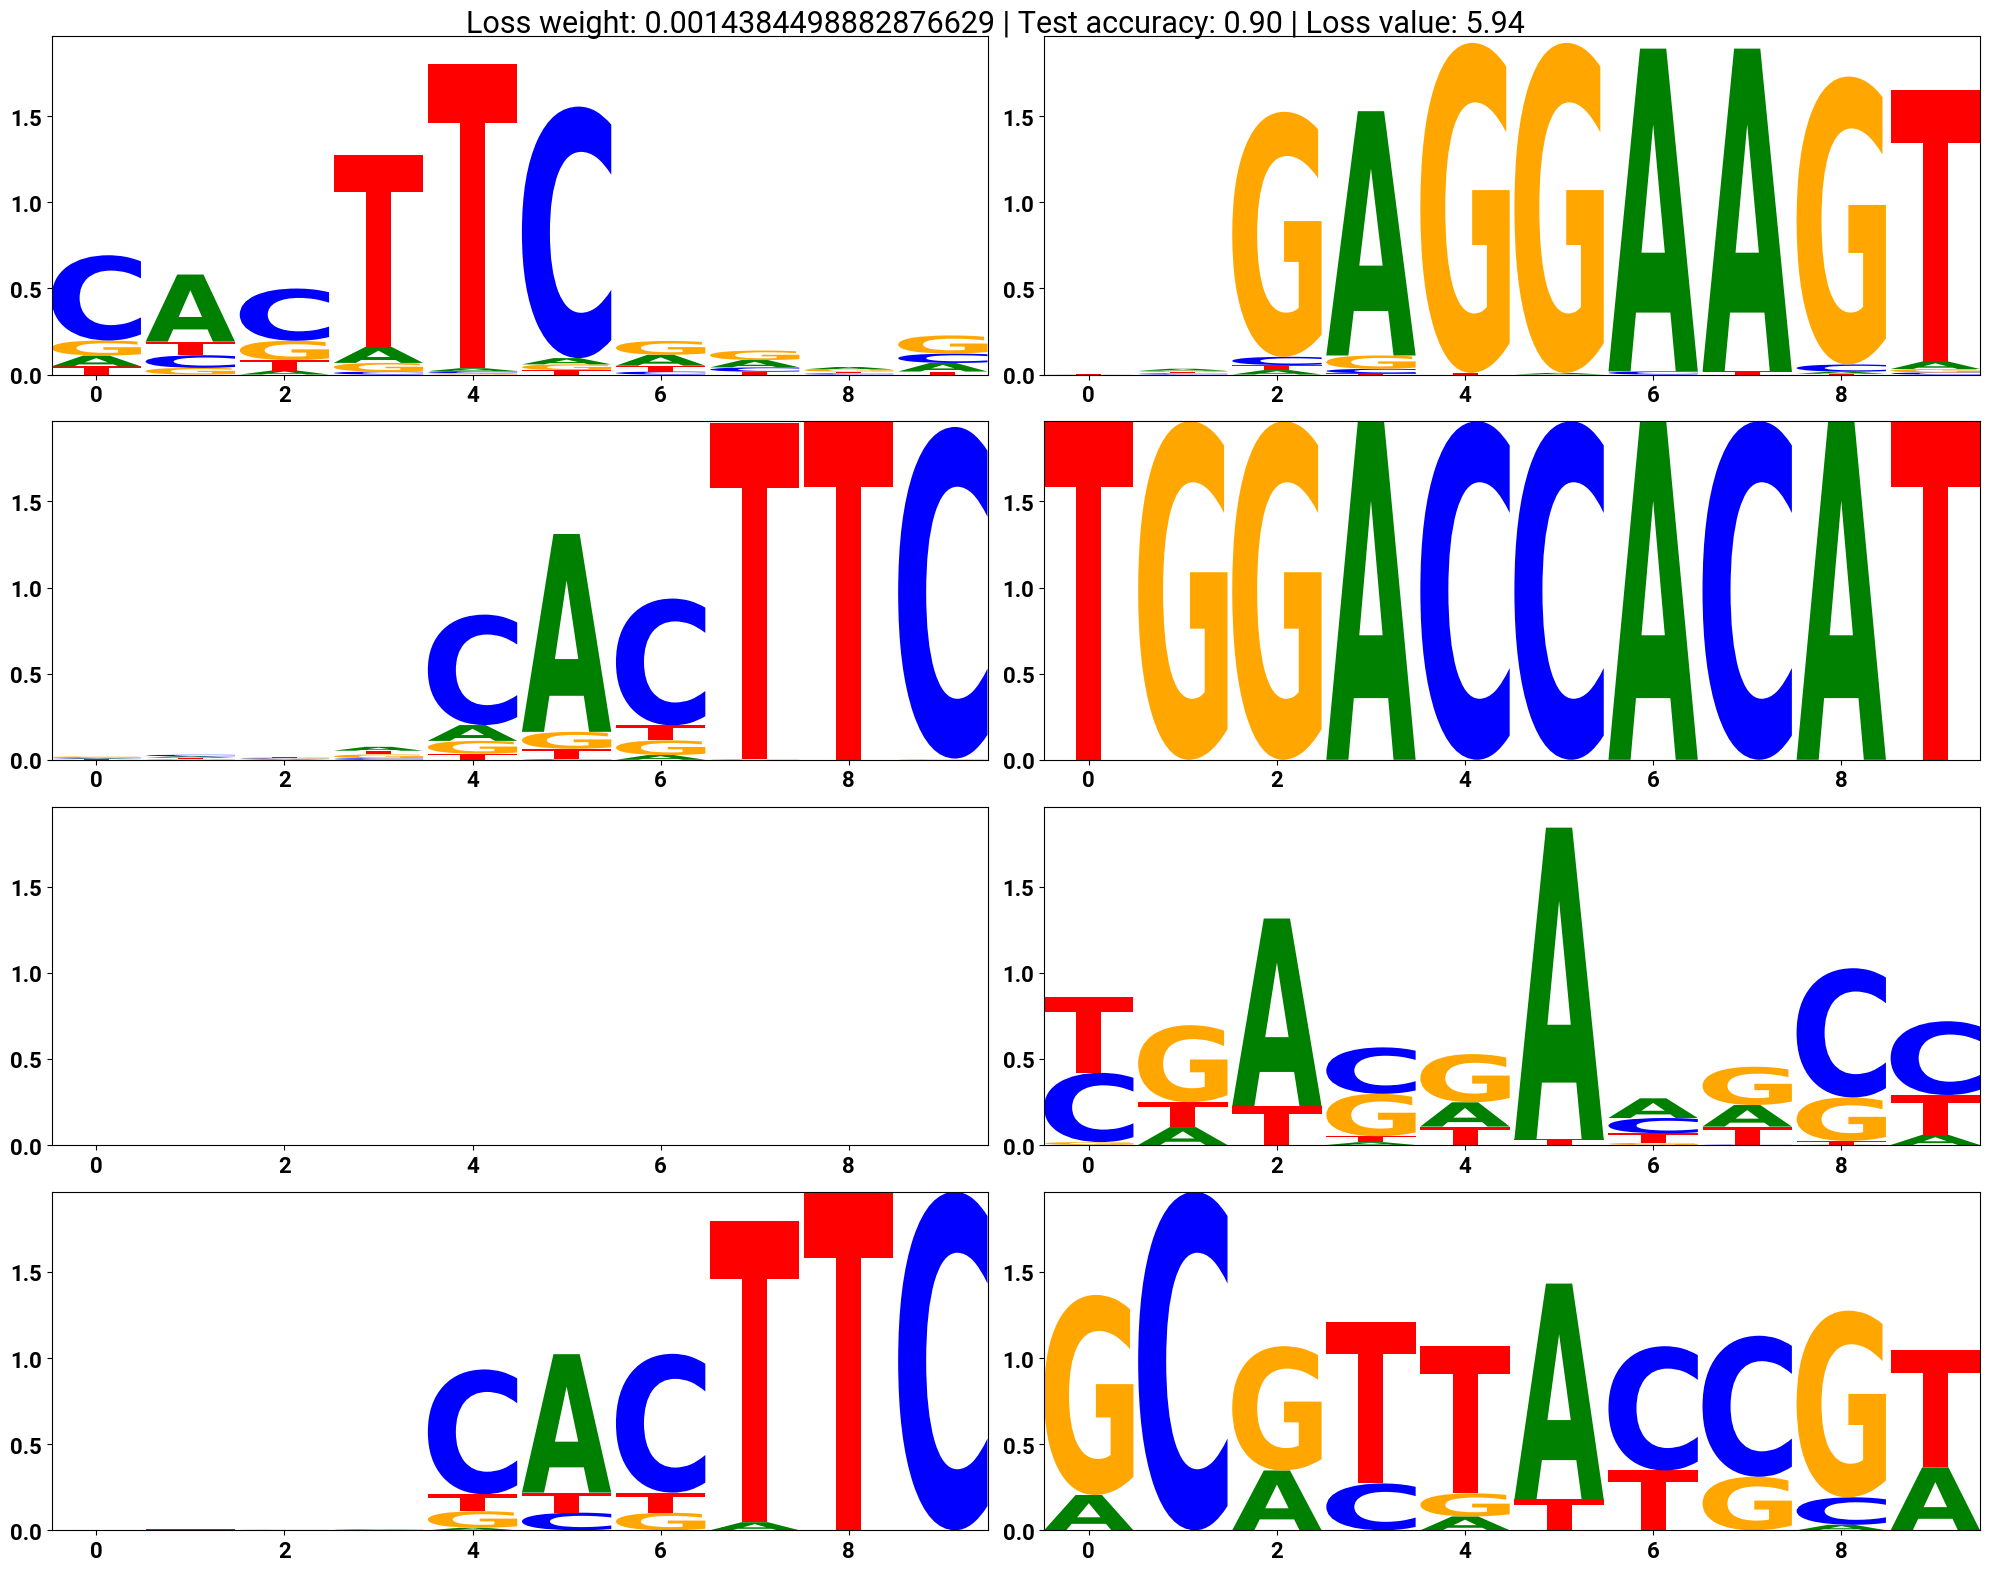

Intepretability score: 2.45


/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
	Loss: 0.1518: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 15.68it/s]
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes

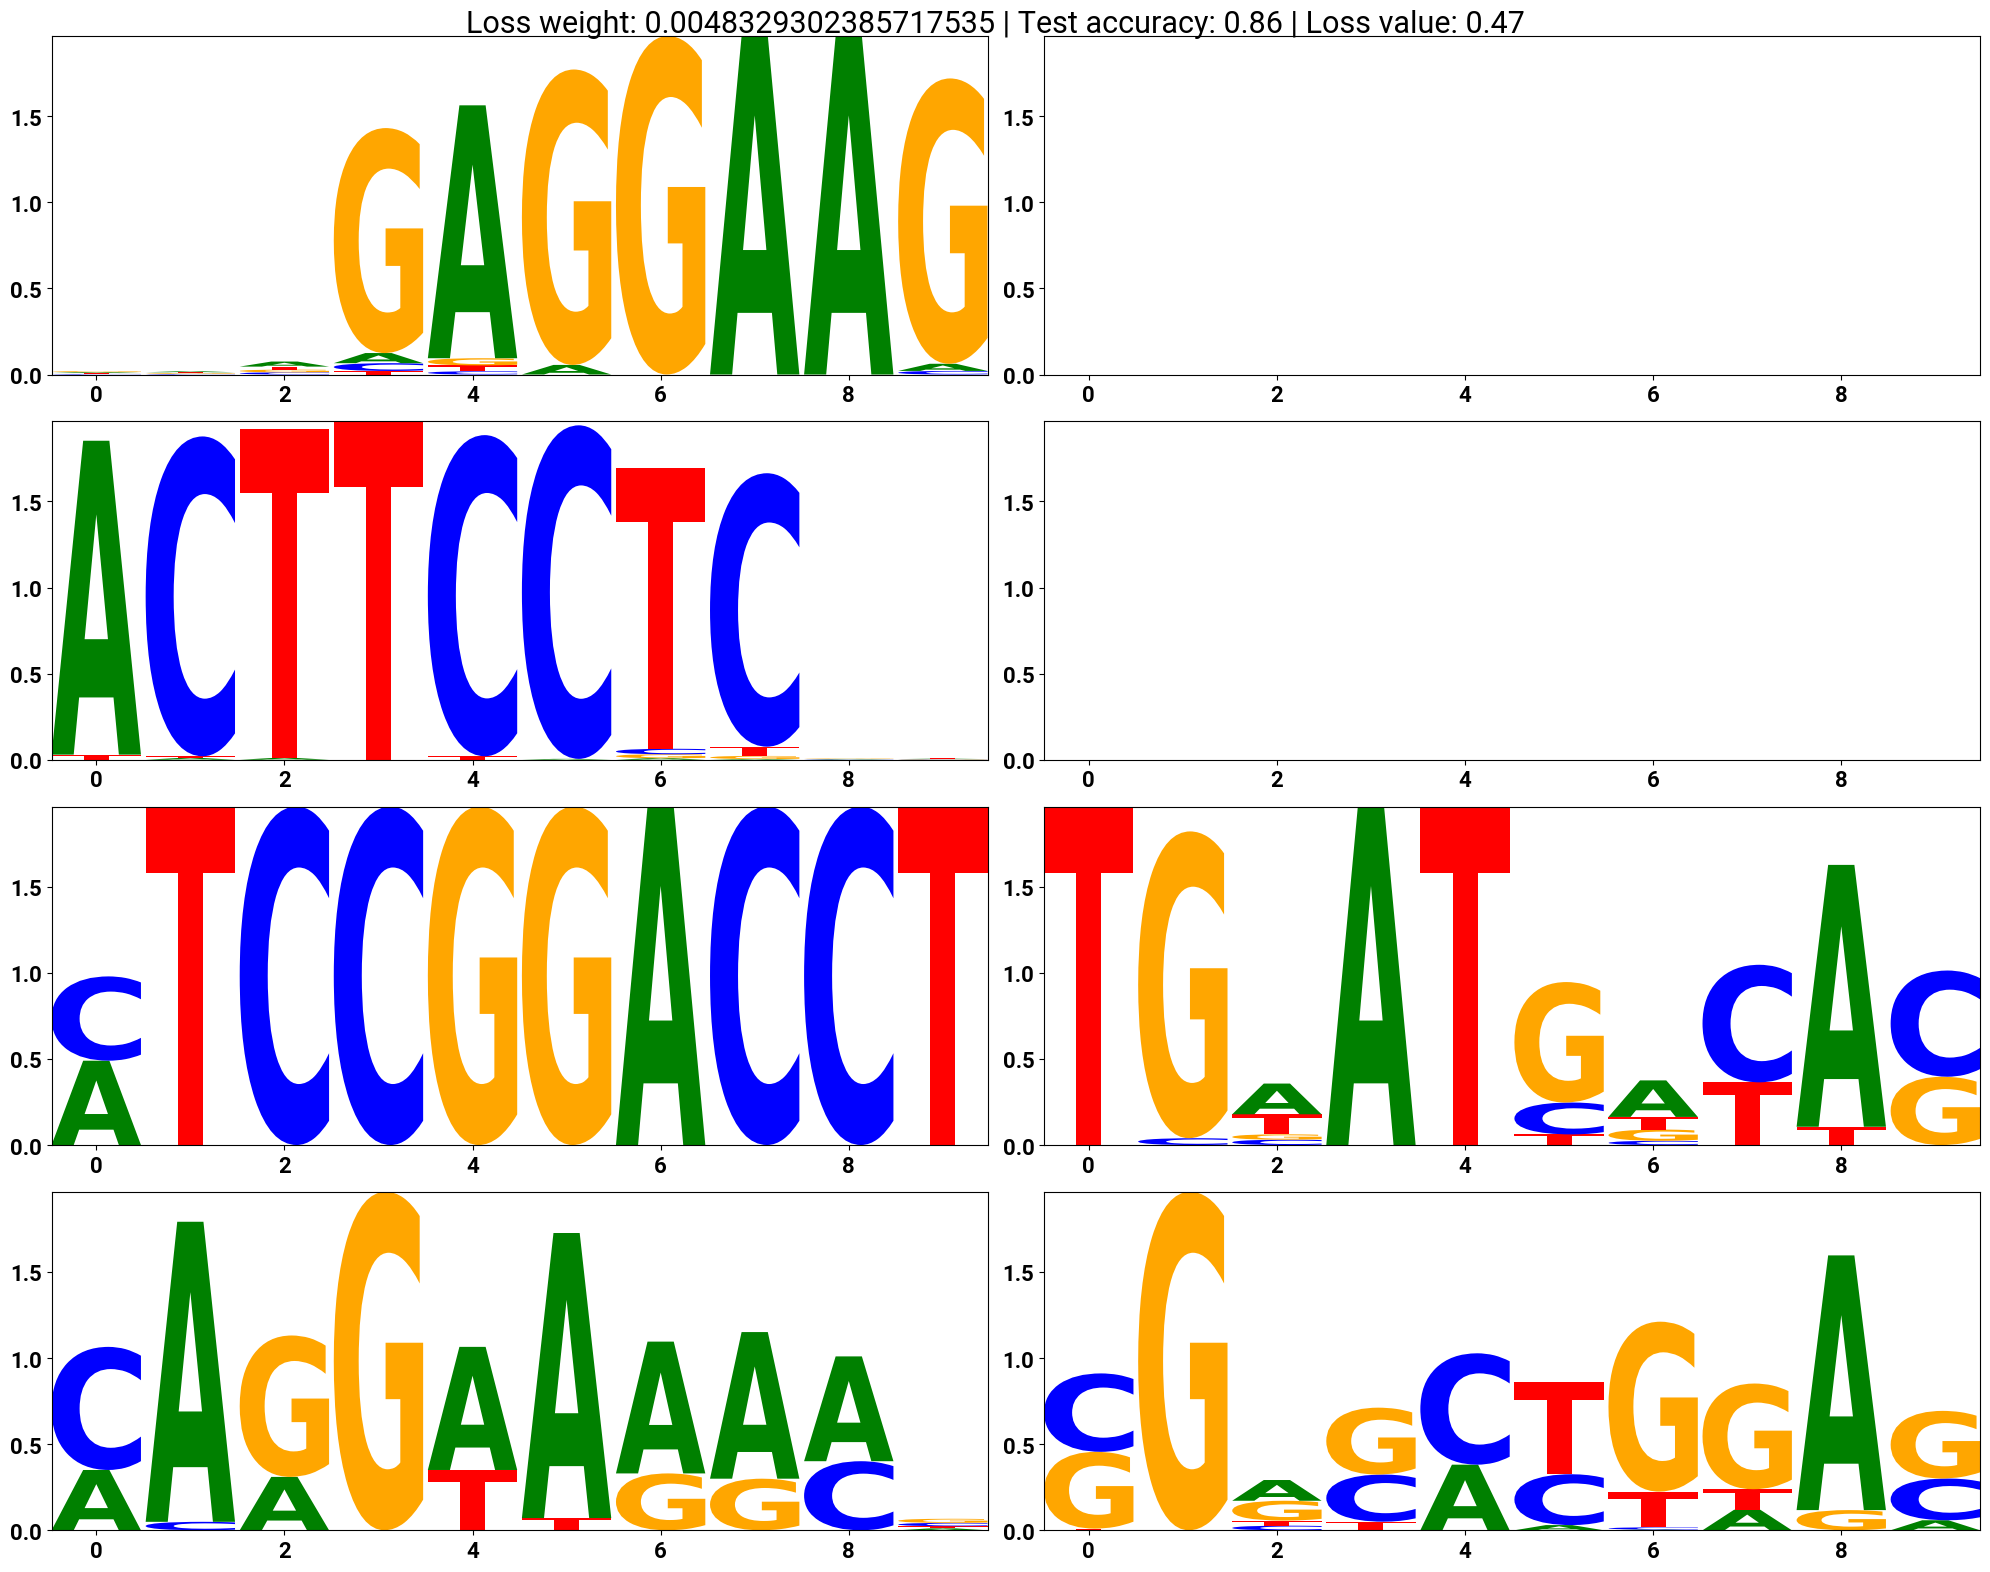

Intepretability score: 1.83


In [13]:
pfms = {}
interpret_scores = {}
for run_num in passing_runs:
    model_path = os.path.join(losstune_model_base, run_num, "last_ckpt.pth")
    model = model_util.load_model(cnn.ConvNet, model_path).to(DEVICE)
    pfms[run_num] = model_to_pfms(model, data_loader)
    fig = plot_motifs.plot_motif_grid([pfm * motif_util.pfm_info_content(pfm)[:, None] for pfm in pfms[run_num]])
    fig.suptitle("Loss weight: %s | Test accuracy: %.2f | Loss value: %.2f" % loss_weight_results[run_num])
    fig.tight_layout()
    plt.show()

    passed_pfms = {i : pfm for i, pfm in enumerate(pfms[run_num]) if np.sum(pfm) > 0}
    tomtom_hits = motif_compare.run_tomtom(
        passed_pfms, true_pfms
    )
    qvals = {i : (np.min(tomtom_hits[i]["q-value"]) if i in tomtom_hits else 1) for i in passed_pfms.keys()}
    interpret_scores[run_num] = np.mean(-np.log10(np.array(list(qvals.values()))))

    print("Intepretability score: %.2f" % interpret_scores[run_num])

### Try a more pathological example

In [14]:
motif_config_path = os.path.join(base_path, "data/simulations/configs/gata_exp_density_config.json")
neg_motif_config_path = os.path.join(base_path, "data/simulations/configs/gata_exp_density_neg_config.json")

In [15]:
train_loader = simulated_dataset.dataset_ex.run(
    "create_data_loader", config_updates={
        "motif_config_path": motif_config_path,
        "input_length": 500,
        "motif_center_dist_bound": 50,
        "batch_size": 128,
        "num_batches": 100,
        "background_match_reject_prob": 1,
        "neg_motif_config_path": neg_motif_config_path
    }
).result
val_loader = simulated_dataset.dataset_ex.run(
    "create_data_loader", config_updates={
        "motif_config_path": motif_config_path,
        "input_length": 500,
        "motif_center_dist_bound": 50,
        "batch_size": 128,
        "num_batches": 10,
        "background_match_reject_prob": 1,
        "neg_motif_config_path": neg_motif_config_path
    }
).result
test_loader = simulated_dataset.dataset_ex.run(
    "create_data_loader", config_updates={
        "motif_config_path": motif_config_path,
        "input_length": 500,
        "motif_center_dist_bound": 50,
        "batch_size": 128,
        "num_batches": 10,
        "background_match_reject_prob": 1,
        "neg_motif_config_path": neg_motif_config_path
    }
).result

WARNING - root - Added new config entry: "motif_config_path"
WARNING - root - Added new config entry: "neg_motif_config_path"
WARNING - sim_dataset - No observers have been added to this run
INFO - sim_dataset - Running command 'create_data_loader'
INFO - sim_dataset - Started
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO - sim_dataset - Result: <torch.utils.data.dataloader.DataLoader object at 0x153e163a1310>
INFO - sim_dataset - Completed after 0:00:00
WARNING - root - Added new config entry: "motif_config_path"
WARNING - root - A

In [16]:
mechint_model = mechint_net.model_ex.run(
    "create_model", config_updates={
        "conv_filter_over_loss_weight": np.concatenate([[0] * 10, np.power(10, np.linspace(0.5, 5, 20)), [1e5] * 10]),
        "conv_filter_l1_loss_weight": np.concatenate([[0] * 10, np.power(10, np.linspace(-3, -2, 20)), [1e-2] * 10]),
        "att_head_sparse_loss_weight": 0
    }
).result.to(DEVICE)

train_model.train_ex.run(
    "train_model", config_updates={
        "train_loader": train_loader,
        "val_loader": val_loader,
        "test_loader": test_loader,
        "model": mechint_model,
        "num_epochs": 40,
        "early_stopping": False
    }
)

WARNING - root - Changed type of config entry "conv_filter_over_loss_weight" from float to ndarray
WARNING - root - Changed type of config entry "conv_filter_l1_loss_weight" from float to ndarray
WARNING - mechint_model - No observers have been added to this run
INFO - mechint_model - Running command 'create_model'
INFO - mechint_model - Started
INFO - mechint_model - Result: MechIntRegNet(
  (conv_layer): Conv1d(4, 8, kernel_size=(10,), stride=(1,))
  (conv_batch_norm): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (syntax_builder): SyntaxBuilderStreamAttention(
    (init_dense): Linear(in_features=24, out_features=32, bias=True)
    (attention_layers): ModuleList(
      (0-3): 4 x StreamAttentionLayer(
        (att_query_linear): Sequential(
          (0): Linear(in_features=128, out_features=32, bias=True)
        )
        (att_value_linear): Linear(in_features=32, out_features=32, bias=True)
        (att_dropout): Dropout(p=0, inplace=False)
    

Train epoch 1: average loss = 0.6640931255



	Loss: 0.5721: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 14.51it/s]

		conv_filter_overlap: 0.010184292476333212
		conv_filter_l1: 24.469463348388672
		att_head_sparse: 8.178275986388325
		pred: 0.5718507912795758
Valid epoch 1: average loss = 0.5718507886



	Loss: 0.5298: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.06it/s]

Train epoch 2: average loss = 0.5707176444



	Loss: 0.4609: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11.57it/s]

		conv_filter_overlap: 0.011085466959048062
		conv_filter_l1: 24.510406494140625
		att_head_sparse: 8.05438440963626
		pred: 0.4655617100681411
Valid epoch 2: average loss = 0.4655617148



	Loss: 0.3624: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.51it/s]

Train epoch 3: average loss = 0.4890147671



	Loss: 0.6969: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12.71it/s]

		conv_filter_overlap: 0.011607347382232546
		conv_filter_l1: 24.49422836303711
		att_head_sparse: 7.914842981472612
		pred: 0.5029715275748459
Valid epoch 3: average loss = 0.5029715270



	Loss: 0.4077: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.88it/s]

Train epoch 4: average loss = 0.4704037738



	Loss: 0.4068: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11.84it/s]

		conv_filter_overlap: 0.013368026037642266
		conv_filter_l1: 24.35890769958496
		att_head_sparse: 7.843943559378386
		pred: 0.41910560368924055
Valid epoch 4: average loss = 0.4191056013



	Loss: 0.4190: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.66it/s]

Train epoch 5: average loss = 0.4679597247



	Loss: 0.4209: 100%|████████████████████████████████████████| 10/10 [00:01<00:00,  9.75it/s]

		conv_filter_overlap: 0.013058382271992741
		conv_filter_l1: 24.289119720458984
		att_head_sparse: 7.691718179360032
		pred: 0.401417662435415
Valid epoch 5: average loss = 0.4014176637



	Loss: 0.3617: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.74it/s]

Train epoch 6: average loss = 0.4025975704



	Loss: 0.3929: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11.35it/s]


		conv_filter_overlap: 0.013632768383104121
		conv_filter_l1: 24.299728393554688
		att_head_sparse: 7.702293431386352
		pred: 0.4282777095335405
Valid epoch 6: average loss = 0.4282777101


	Loss: 0.4057: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.07it/s]

Train epoch 7: average loss = 0.3847359203



	Loss: 0.2936: 100%|████████████████████████████████████████| 10/10 [00:01<00:00,  9.77it/s]

		conv_filter_overlap: 0.014241544454125687
		conv_filter_l1: 24.234657287597656
		att_head_sparse: 7.69856283813715
		pred: 0.371971976443092
Valid epoch 7: average loss = 0.3719719768



	Loss: 0.4173: 100%|██████████████████████████████████████| 100/100 [00:08<00:00, 12.38it/s]

Train epoch 8: average loss = 0.3648173331



	Loss: 0.3624: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11.22it/s]


		conv_filter_overlap: 0.014463179567974294
		conv_filter_l1: 24.244060516357422
		att_head_sparse: 7.445949282497168
		pred: 0.3599581167252836
Valid epoch 8: average loss = 0.3599581152


	Loss: 0.3050: 100%|██████████████████████████████████████| 100/100 [00:08<00:00, 11.19it/s]


Train epoch 9: average loss = 0.4066510376


	Loss: 0.2652: 100%|████████████████████████████████████████| 10/10 [00:01<00:00,  9.93it/s]

		conv_filter_overlap: 0.014650039236585144
		conv_filter_l1: 24.22620391845703
		att_head_sparse: 7.461074514314532
		pred: 0.3567164210058763
Valid epoch 9: average loss = 0.3567164183



	Loss: 0.2703: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.22it/s]

Train epoch 10: average loss = 0.3269115674



	Loss: 0.2712: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13.47it/s]

		conv_filter_overlap: 0.014711382034874987
		conv_filter_l1: 24.039897918701172
		att_head_sparse: 7.456674141809344
		pred: 0.27838459756521844
Valid epoch 10: average loss = 0.2783845991



	Loss: 0.4232: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.29it/s]

Train epoch 11: average loss = 0.3787160343



	Loss: 0.3827: 100%|████████████████████████████████████████| 10/10 [00:01<00:00,  8.82it/s]

		conv_filter_overlap: 0.009836720821476774
		conv_filter_l1: 22.69891357421875
		att_head_sparse: 7.427616329491139
		pred: 0.32828166170756956
Valid epoch 11: average loss = 0.3820870131



	Loss: 0.4916: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.09it/s]

Train epoch 12: average loss = 0.4149752912



	Loss: 0.3142: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13.46it/s]


		conv_filter_overlap: 0.006614249912308879
		conv_filter_l1: 21.761463165283203
		att_head_sparse: 7.493859633058309
		pred: 0.2697216212204239
Valid epoch 12: average loss = 0.3303714573


	Loss: 0.3013: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.34it/s]

Train epoch 13: average loss = 0.4151698419



	Loss: 0.4317: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13.56it/s]

		conv_filter_overlap: 0.0042052531238368825
		conv_filter_l1: 20.86255645751953
		att_head_sparse: 7.466305246576667
		pred: 0.35271997112122333
Valid epoch 13: average loss = 0.4188846588



	Loss: 0.4505: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.76it/s]

Train epoch 14: average loss = 0.4352508968



	Loss: 0.3305: 100%|████████████████████████████████████████| 10/10 [00:01<00:00,  9.53it/s]


		conv_filter_overlap: 0.002657739240567025
		conv_filter_l1: 20.055400848388672
		att_head_sparse: 7.3717126496136185
		pred: 0.316500962855298
Valid epoch 14: average loss = 0.3885054082


	Loss: 0.3828: 100%|██████████████████████████████████████| 100/100 [00:08<00:00, 12.33it/s]

Train epoch 15: average loss = 0.4383773595



	Loss: 0.2941: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 15.41it/s]

		conv_filter_overlap: 0.0014767327282243059
		conv_filter_l1: 19.328344345092773
		att_head_sparse: 7.369042669981718
		pred: 0.36017667140613413
Valid epoch 15: average loss = 0.4329301298



	Loss: 0.3744: 100%|██████████████████████████████████████| 100/100 [00:08<00:00, 12.34it/s]

Train epoch 16: average loss = 0.4390437773



	Loss: 0.4947: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 14.01it/s]

		conv_filter_overlap: 0.0008003648224075733
		conv_filter_l1: 18.62834930419922
		att_head_sparse: 7.296293759718537
		pred: 0.3891238116482782
Valid epoch 16: average loss = 0.4619502932



	Loss: 0.4590: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.79it/s]

Train epoch 17: average loss = 0.4227600205



	Loss: 0.4310: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 15.12it/s]

		conv_filter_overlap: 0.00046223396398090697
		conv_filter_l1: 18.118026733398438
		att_head_sparse: 7.476446671038866
		pred: 0.33185948982568336
Valid epoch 17: average loss = 0.4078884333



	Loss: 0.3603: 100%|██████████████████████████████████████| 100/100 [00:08<00:00, 11.91it/s]

Train epoch 18: average loss = 0.4388703939



	Loss: 0.3839: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13.87it/s]

		conv_filter_overlap: 0.0002846178995127957
		conv_filter_l1: 17.459135055541992
		att_head_sparse: 7.6206691764295105
		pred: 0.3299268245233634
Valid epoch 18: average loss = 0.4116473615



	Loss: 0.4332: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.94it/s]

Train epoch 19: average loss = 0.4376426339



	Loss: 0.3425: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13.16it/s]

		conv_filter_overlap: 0.0001660939194778166
		conv_filter_l1: 16.851709365844727
		att_head_sparse: 7.670551647990942
		pred: 0.2965746259806565
Valid epoch 19: average loss = 0.3822250485



	Loss: 0.5580: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.70it/s]

Train epoch 20: average loss = 0.4352911335



	Loss: 0.5415: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12.58it/s]

		conv_filter_overlap: 8.682330883118539e-05
		conv_filter_l1: 16.19844627380371
		att_head_sparse: 7.587432796135545
		pred: 0.37612251925725104
Valid epoch 20: average loss = 0.4615067214



	Loss: 0.3694: 100%|██████████████████████████████████████| 100/100 [00:08<00:00, 12.40it/s]

Train epoch 21: average loss = 0.4311324674



	Loss: 0.3766: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11.22it/s]

		conv_filter_overlap: 4.6316440761984265e-05
		conv_filter_l1: 15.325736045837402
		att_head_sparse: 7.70388310700655
		pred: 0.27730418304154225
Valid epoch 21: average loss = 0.3630061209



	Loss: 0.5384: 100%|██████████████████████████████████████| 100/100 [00:08<00:00, 12.30it/s]

Train epoch 22: average loss = 0.4294655409



	Loss: 0.3913: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11.48it/s]

		conv_filter_overlap: 2.4990790493006898e-05
		conv_filter_l1: 14.46473503112793
		att_head_sparse: 7.775737200677395
		pred: 0.3254084207093683
Valid epoch 22: average loss = 0.4121138245



	Loss: 0.4294: 100%|██████████████████████████████████████| 100/100 [00:08<00:00, 11.81it/s]

Train epoch 23: average loss = 0.3944393742



	Loss: 0.3816: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13.06it/s]

		conv_filter_overlap: 1.3420411566400503e-05
		conv_filter_l1: 13.508073806762695
		att_head_sparse: 7.890886941179633
		pred: 0.29911241252484616
Valid epoch 23: average loss = 0.3864482999



	Loss: 0.4610: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.30it/s]

Train epoch 24: average loss = 0.4111637554



	Loss: 0.3462: 100%|████████████████████████████████████████| 10/10 [00:01<00:00,  9.85it/s]

		conv_filter_overlap: 6.535045770483805e-06
		conv_filter_l1: 12.504364013671875
		att_head_sparse: 7.798861020803452
		pred: 0.27688225001061256
Valid epoch 24: average loss = 0.3621003777



	Loss: 0.4222: 100%|██████████████████████████████████████| 100/100 [00:08<00:00, 12.10it/s]

Train epoch 25: average loss = 0.4355025125



	Loss: 0.3441: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10.71it/s]

		conv_filter_overlap: 4.410397910259434e-06
		conv_filter_l1: 11.488397598266602
		att_head_sparse: 7.828338976576925
		pred: 0.2749623415467795
Valid epoch 25: average loss = 0.3664964586



	Loss: 0.3858: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.52it/s]

Train epoch 26: average loss = 0.4108527765



	Loss: 0.4081: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 16.56it/s]


		conv_filter_overlap: 1.6048323265849262e-06
		conv_filter_l1: 10.291448593139648
		att_head_sparse: 7.773010552674532
		pred: 0.2841131885127197
Valid epoch 26: average loss = 0.3656088442


	Loss: 0.3674: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.02it/s]

Train epoch 27: average loss = 0.4001464680



	Loss: 0.4841: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 15.93it/s]

		conv_filter_overlap: 6.184332895453615e-07
		conv_filter_l1: 8.973122596740723
		att_head_sparse: 7.7685556672513485
		pred: 0.2921210168464768
Valid epoch 27: average loss = 0.3665454030



	Loss: 0.2384: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.35it/s]

Train epoch 28: average loss = 0.3774036328



	Loss: 0.4435: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 14.14it/s]

		conv_filter_overlap: 4.141007533903229e-07
		conv_filter_l1: 7.868881702423096
		att_head_sparse: 7.639694090560079
		pred: 0.38707522168845115
Valid epoch 28: average loss = 0.4627400935



	Loss: 0.3992: 100%|██████████████████████████████████████| 100/100 [00:08<00:00, 12.31it/s]

Train epoch 29: average loss = 0.3755108222



	Loss: 0.5107: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11.11it/s]


		conv_filter_overlap: 3.4455694434276653e-07
		conv_filter_l1: 6.893890380859375
		att_head_sparse: 7.659072398766876
		pred: 0.29521498499436805
Valid epoch 29: average loss = 0.3762575567


	Loss: 0.4194: 100%|██████████████████████████████████████| 100/100 [00:08<00:00, 11.50it/s]

Train epoch 30: average loss = 0.3578115068



	Loss: 0.3039: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11.01it/s]


		conv_filter_overlap: 2.975962069939886e-07
		conv_filter_l1: 6.082096576690674
		att_head_sparse: 7.684655527025461
		pred: 0.26874587800828065
Valid epoch 30: average loss = 0.3593264520


	Loss: 0.3192: 100%|██████████████████████████████████████| 100/100 [00:08<00:00, 12.26it/s]

Train epoch 31: average loss = 0.3809229162



	Loss: 0.4183: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10.21it/s]

		conv_filter_overlap: 3.22608416852832e-07
		conv_filter_l1: 5.489776611328125
		att_head_sparse: 7.61581876128912
		pred: 0.2804786069255215
Valid epoch 31: average loss = 0.3676372141



	Loss: 0.3373: 100%|██████████████████████████████████████| 100/100 [00:08<00:00, 11.64it/s]

Train epoch 32: average loss = 0.3615983903



	Loss: 0.3306: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 16.41it/s]

		conv_filter_overlap: 2.9377411104314357e-07
		conv_filter_l1: 5.018411159515381
		att_head_sparse: 7.54057438224554
		pred: 0.2879278382975713
Valid epoch 32: average loss = 0.3674893647



	Loss: 0.4325: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.69it/s]

Train epoch 33: average loss = 0.3386690852



	Loss: 0.3299: 100%|████████████████████████████████████████| 10/10 [00:01<00:00,  9.78it/s]

		conv_filter_overlap: 2.857792477634069e-07
		conv_filter_l1: 4.638469696044922
		att_head_sparse: 7.386273550242185
		pred: 0.2565109744771462
Valid epoch 33: average loss = 0.3314735979



	Loss: 0.2603: 100%|██████████████████████████████████████| 100/100 [00:08<00:00, 12.17it/s]

Train epoch 34: average loss = 0.3367981009



	Loss: 0.2755: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 14.54it/s]

		conv_filter_overlap: 2.3051048658184748e-07
		conv_filter_l1: 4.323974609375
		att_head_sparse: 7.386864073574543
		pred: 0.2515540421452783
Valid epoch 34: average loss = 0.3178448409



	Loss: 0.2290: 100%|██████████████████████████████████████| 100/100 [00:08<00:00, 12.41it/s]

Train epoch 35: average loss = 0.3453495930



	Loss: 0.3561: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11.52it/s]

		conv_filter_overlap: 1.8072019091625036e-07
		conv_filter_l1: 4.08634090423584
		att_head_sparse: 7.373767871782183
		pred: 0.23858291346090255
Valid epoch 35: average loss = 0.2975183427



	Loss: 0.2517: 100%|██████████████████████████████████████| 100/100 [00:08<00:00, 12.22it/s]

Train epoch 36: average loss = 0.3258272526



	Loss: 0.3731: 100%|████████████████████████████████████████| 10/10 [00:01<00:00,  9.88it/s]

		conv_filter_overlap: 2.491306326318776e-07
		conv_filter_l1: 3.837047576904297
		att_head_sparse: 7.255948711559176
		pred: 0.26222843915246585
Valid epoch 36: average loss = 0.3255119801



	Loss: 0.3406: 100%|██████████████████████████████████████| 100/100 [00:08<00:00, 12.28it/s]

Train epoch 37: average loss = 0.3270690894



	Loss: 0.4693: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12.11it/s]


		conv_filter_overlap: 2.3295458258243418e-07
		conv_filter_l1: 3.663529396057129
		att_head_sparse: 7.2488313622772695
		pred: 0.3371143080314482
Valid epoch 37: average loss = 0.3970450550


	Loss: 0.2753: 100%|██████████████████████████████████████| 100/100 [00:08<00:00, 12.25it/s]

Train epoch 38: average loss = 0.3381091699



	Loss: 0.2234: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11.03it/s]

		conv_filter_overlap: 1.9708748591751314e-07
		conv_filter_l1: 3.5267579555511475
		att_head_sparse: 7.23812855258584
		pred: 0.26580613256938934
Valid epoch 38: average loss = 0.3207824603



	Loss: 0.3105: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.55it/s]

Train epoch 39: average loss = 0.3144127104



	Loss: 0.3232: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13.58it/s]

		conv_filter_overlap: 1.7318273251437643e-07
		conv_filter_l1: 3.3891749382019043
		att_head_sparse: 7.056655076146126
		pred: 0.293161945375698
Valid epoch 39: average loss = 0.3443719745



	Loss: 0.3711: 100%|██████████████████████████████████████| 100/100 [00:08<00:00, 12.01it/s]

Train epoch 40: average loss = 0.3285741262



	Loss: 0.4203: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11.73it/s]

		conv_filter_overlap: 2.818066317203383e-07
		conv_filter_l1: 3.2036712169647217
		att_head_sparse: 7.084289006516338
		pred: 0.2744357366728195
Valid epoch 40: average loss = 0.3346531123
Computing test-set predictions:



	Loss: 0.3219: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11.52it/s]
INFO - train - Completed after 0:07:31


Computing test-set performance:
	acc     : 0.8773
	pos_acc : 0.8047
	neg_acc : 0.9500
	auroc   : 0.9678
	precis  : 0.9415
	recall  : 0.8047
	auprc   : 0.9546
	c_precis: 0.9415
	c_recall: 0.8047
	c_auprc : 0.9546


In [17]:
cnn_filteroverlap_model = cnn.model_ex.run(
    "create_model", config_updates={
        "conv_filter_over_loss_weight": np.concatenate([[0] * 10, np.power(10, np.linspace(0.5, 5, 20)), [1e5] * 10]),
        "conv_filter_l1_loss_weight": np.concatenate([[0] * 10, np.power(10, np.linspace(-3, -2, 20)), [1e-2] * 10]),
        "conv_act_l1_loss_weight": 0
    }
).result.to(DEVICE)

train_model.train_ex.run(
    "train_model", config_updates={
        "train_loader": train_loader,
        "val_loader": val_loader,
        "test_loader": test_loader,
        "model": cnn_filteroverlap_model,
        "num_epochs": 40,
        "early_stopping": False
    }
)

WARNING - root - Changed type of config entry "conv_filter_over_loss_weight" from int to ndarray
WARNING - root - Changed type of config entry "conv_filter_l1_loss_weight" from int to ndarray
WARNING - cnn_model - No observers have been added to this run
INFO - cnn_model - Running command 'create_model'
INFO - cnn_model - Started
INFO - cnn_model - Result: ConvNet(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv1d(4, 8, kernel_size=(10,), stride=(1,))
      (1): ReLU()
      (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1-2): 2 x Sequential(
      (0): Conv1d(8, 8, kernel_size=(5,), stride=(1,))
      (1): ReLU()
      (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (max_pool_layer): MaxPool1d(kernel_size=40, stride=40, padding=0, dilation=1, ceil_mode=False)
  (fc_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=96, out_features=10, bias=True)
     

Train epoch 1: average loss = 0.7082798612



	Loss: 0.6875: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10.87it/s]

		conv_filter_overlap: 0.015489207622158574
		conv_filter_l1: 25.261850357055664
		conv_act_l1: 575.2953699588776
		pred: 0.6949697985081003
Valid epoch 1: average loss = 0.6949697971



	Loss: 0.6567: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 14.09it/s]

Train epoch 2: average loss = 0.6751108181



	Loss: 0.6869: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 15.25it/s]


		conv_filter_overlap: 0.016349917191837447
		conv_filter_l1: 25.15224838256836
		conv_act_l1: 608.4121589183808
		pred: 0.641361930326093
Valid epoch 2: average loss = 0.6413619399


	Loss: 0.5781: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.43it/s]

Train epoch 3: average loss = 0.6119280094



	Loss: 0.5786: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11.96it/s]

		conv_filter_overlap: 0.018332395546894985
		conv_filter_l1: 25.281782150268555
		conv_act_l1: 656.0126080036164
		pred: 0.5707222154829651
Valid epoch 3: average loss = 0.5707222104



	Loss: 0.4806: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.58it/s]

Train epoch 4: average loss = 0.5543531227



	Loss: 0.4773: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13.30it/s]

		conv_filter_overlap: 0.02038058684265707
		conv_filter_l1: 25.2562255859375
		conv_act_l1: 713.4466439723968
		pred: 0.521091906267975
Valid epoch 4: average loss = 0.5210919112



	Loss: 0.4794: 100%|██████████████████████████████████████| 100/100 [00:06<00:00, 14.56it/s]

Train epoch 5: average loss = 0.5165041071



	Loss: 0.5478: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12.33it/s]

		conv_filter_overlap: 0.023468033094832207
		conv_filter_l1: 25.153705596923828
		conv_act_l1: 818.2526481628418
		pred: 0.5001837685169448
Valid epoch 5: average loss = 0.5001837611



	Loss: 0.4150: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.74it/s]

Train epoch 6: average loss = 0.5034353748



	Loss: 0.6788: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12.74it/s]

		conv_filter_overlap: 0.024369916997966357
		conv_filter_l1: 25.22347640991211
		conv_act_l1: 834.7834486961365
		pred: 0.5262304126539675
Valid epoch 6: average loss = 0.5262304157



	Loss: 0.4820: 100%|██████████████████████████████████████| 100/100 [00:06<00:00, 14.75it/s]

Train epoch 7: average loss = 0.4853284302



	Loss: 0.5055: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13.07it/s]

		conv_filter_overlap: 0.02446881043142639
		conv_filter_l1: 25.33657455444336
		conv_act_l1: 825.0191469669342
		pred: 0.46683481747058975
Valid epoch 7: average loss = 0.4668348104



	Loss: 0.5265: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.44it/s]

Train epoch 8: average loss = 0.4709114766



	Loss: 0.4992: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13.47it/s]


		conv_filter_overlap: 0.025170874956529588
		conv_filter_l1: 25.37895393371582
		conv_act_l1: 845.7717060089111
		pred: 0.46862744277550517
Valid epoch 8: average loss = 0.4686274379


	Loss: 0.4596: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.78it/s]

Train epoch 9: average loss = 0.4498692787



	Loss: 0.4429: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10.97it/s]


		conv_filter_overlap: 0.02621688983635977
		conv_filter_l1: 25.376577377319336
		conv_act_l1: 878.1436068534852
		pred: 0.450799936167914
Valid epoch 9: average loss = 0.4507999420


	Loss: 0.4900: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 14.06it/s]

Train epoch 10: average loss = 0.4355832857



	Loss: 0.5302: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11.75it/s]

		conv_filter_overlap: 0.025920863018836827
		conv_filter_l1: 25.413787841796875
		conv_act_l1: 875.2817165851593
		pred: 0.4575044279474696
Valid epoch 10: average loss = 0.4575044245



	Loss: 0.4301: 100%|██████████████████████████████████████| 100/100 [00:06<00:00, 14.46it/s]

Train epoch 11: average loss = 0.5023172861



	Loss: 0.4817: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13.26it/s]

		conv_filter_overlap: 0.010225751681718975
		conv_filter_l1: 22.967479705810547
		conv_act_l1: 419.10129115581515
		pred: 0.41311101614692236
Valid epoch 11: average loss = 0.4684151620



	Loss: 0.4358: 100%|██████████████████████████████████████| 100/100 [00:06<00:00, 14.86it/s]

Train epoch 12: average loss = 0.5023610628



	Loss: 0.5312: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12.70it/s]


		conv_filter_overlap: 0.004719870000917581
		conv_filter_l1: 20.959293365478516
		conv_act_l1: 226.77151614427567
		pred: 0.4248633499028074
Valid epoch 12: average loss = 0.4742726922


	Loss: 0.3658: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.76it/s]

Train epoch 13: average loss = 0.4835255569



	Loss: 0.5079: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11.89it/s]


		conv_filter_overlap: 0.0029081843995300005
		conv_filter_l1: 19.302648544311523
		conv_act_l1: 154.53747934103012
		pred: 0.4050770895718415
Valid epoch 13: average loss = 0.4570459485


	Loss: 0.4688: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.67it/s]

Train epoch 14: average loss = 0.4808306086



	Loss: 0.5062: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 17.35it/s]

		conv_filter_overlap: 0.001594667057361221
		conv_filter_l1: 17.662769317626953
		conv_act_l1: 96.84101257324218
		pred: 0.4300042780005242
Valid epoch 14: average loss = 0.4813051254



	Loss: 0.4274: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.83it/s]

Train epoch 15: average loss = 0.4819101688



	Loss: 0.4061: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12.90it/s]

		conv_filter_overlap: 0.0007401935517464154
		conv_filter_l1: 16.298736572265625
		conv_act_l1: 52.72490735352039
		pred: 0.43071383339547537
Valid epoch 15: average loss = 0.4779148102



	Loss: 0.5261: 100%|██████████████████████████████████████| 100/100 [00:06<00:00, 14.92it/s]

Train epoch 16: average loss = 0.4697639182



	Loss: 0.3895: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 14.57it/s]


		conv_filter_overlap: 0.0004619647469098709
		conv_filter_l1: 15.202722549438477
		conv_act_l1: 37.60108380317688
		pred: 0.4463101342802929
Valid epoch 16: average loss = 0.4965028644


	Loss: 0.4992: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.97it/s]

Train epoch 17: average loss = 0.4820569530



	Loss: 0.4584: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 16.49it/s]

		conv_filter_overlap: 0.00026804579977124376
		conv_filter_l1: 14.399553298950195
		conv_act_l1: 23.060717594623565
		pred: 0.39900826437487924
Valid epoch 17: average loss = 0.4511521041



	Loss: 0.3930: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.68it/s]

Train epoch 18: average loss = 0.4636469370



	Loss: 0.5663: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10.44it/s]

		conv_filter_overlap: 0.000164637553183411
		conv_filter_l1: 13.458491325378418
		conv_act_l1: 20.436868737637997
		pred: 0.41220303706872985
Valid epoch 18: average loss = 0.4673206002



	Loss: 0.5202: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.44it/s]

Train epoch 19: average loss = 0.4564303297



	Loss: 0.4407: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12.45it/s]

		conv_filter_overlap: 0.00010364706304812898
		conv_filter_l1: 12.715339660644531
		conv_act_l1: 15.377321948856116
		pred: 0.3972200441782661
Valid epoch 19: average loss = 0.4564673126



	Loss: 0.5036: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.36it/s]

Train epoch 20: average loss = 0.4607527891



	Loss: 0.5100: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11.62it/s]


		conv_filter_overlap: 6.686244317677392e-05
		conv_filter_l1: 12.090066909790039
		conv_act_l1: 11.89854676052928
		pred: 0.3877637958035393
Valid epoch 20: average loss = 0.4523741096


	Loss: 0.4890: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.98it/s]

Train epoch 21: average loss = 0.4712395579



	Loss: 0.3936: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 14.36it/s]

		conv_filter_overlap: 3.6981235913913225e-05
		conv_filter_l1: 11.582032203674316
		conv_act_l1: 10.397696059942245
		pred: 0.40270855581570686
Valid epoch 21: average loss = 0.4689371586



	Loss: 0.3701: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.05it/s]

Train epoch 22: average loss = 0.4713014606



	Loss: 0.4117: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12.60it/s]

		conv_filter_overlap: 2.2581238827967808e-05
		conv_filter_l1: 11.034854888916016
		conv_act_l1: 5.680233056470752
		pred: 0.3987379724770335
Valid epoch 22: average loss = 0.4693644732



	Loss: 0.4865: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.28it/s]

Train epoch 23: average loss = 0.4737072739



	Loss: 0.4351: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12.74it/s]


		conv_filter_overlap: 1.4196511896358288e-05
		conv_filter_l1: 10.487470626831055
		conv_act_l1: 6.059804831072688
		pred: 0.4081425561900005
Valid epoch 23: average loss = 0.4842523992


	Loss: 0.4881: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.12it/s]

Train epoch 24: average loss = 0.4829651478



	Loss: 0.5553: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 14.89it/s]

		conv_filter_overlap: 6.6443141605532215e-06
		conv_filter_l1: 10.047273635864258
		conv_act_l1: 5.593450137227774
		pred: 0.4247820534420498
Valid epoch 24: average loss = 0.4985396385



	Loss: 0.5233: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.92it/s]

Train epoch 25: average loss = 0.4866165444



	Loss: 0.4292: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13.92it/s]


		conv_filter_overlap: 6.642860151728769e-06
		conv_filter_l1: 9.581035614013672
		conv_act_l1: 3.8641793323680758
		pred: 0.40345711956670127
Valid epoch 25: average loss = 0.4991928518


	Loss: 0.4824: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.27it/s]

Train epoch 26: average loss = 0.5116144410



	Loss: 0.5126: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11.69it/s]

		conv_filter_overlap: 3.993624150933073e-06
		conv_filter_l1: 9.047107696533203
		conv_act_l1: 4.900992490909994
		pred: 0.3856641620270693
Valid epoch 26: average loss = 0.4864621460



	Loss: 0.4808: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.77it/s]

Train epoch 27: average loss = 0.5100655389



	Loss: 0.4850: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13.18it/s]

		conv_filter_overlap: 2.0908426019428106e-06
		conv_filter_l1: 8.58099365234375
		conv_act_l1: 1.6871931194327772
		pred: 0.4267340942864394
Valid epoch 27: average loss = 0.5271073490



	Loss: 0.5782: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.64it/s]

Train epoch 28: average loss = 0.5246555585



	Loss: 0.5323: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12.62it/s]

		conv_filter_overlap: 9.618572772707168e-07
		conv_filter_l1: 8.115777969360352
		conv_act_l1: 3.3095182394608855
		pred: 0.38211163111413954
Valid epoch 28: average loss = 0.4781176627



	Loss: 0.5146: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.68it/s]

Train epoch 29: average loss = 0.5319432205



	Loss: 0.6139: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11.83it/s]

		conv_filter_overlap: 5.698587212943362e-07
		conv_filter_l1: 7.804065704345703
		conv_act_l1: 4.270830505155027
		pred: 0.4309663053132226
Valid epoch 29: average loss = 0.5331311882



	Loss: 0.5178: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.99it/s]

Train epoch 30: average loss = 0.5426836875



	Loss: 0.6025: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 16.12it/s]

		conv_filter_overlap: 6.147391350297404e-07
		conv_filter_l1: 7.354227066040039
		conv_act_l1: 2.523061960283667
		pred: 0.4145157048812507
Valid epoch 30: average loss = 0.5495318770



	Loss: 0.4587: 100%|██████████████████████████████████████| 100/100 [00:08<00:00, 11.98it/s]

Train epoch 31: average loss = 0.5475601575



	Loss: 0.5116: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13.00it/s]

		conv_filter_overlap: 3.6322921298792555e-07
		conv_filter_l1: 6.876998424530029
		conv_act_l1: 2.5757703082636
		pred: 0.42424742103387414
Valid epoch 31: average loss = 0.5293403268



	Loss: 0.5993: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.69it/s]

Train epoch 32: average loss = 0.5195041013



	Loss: 0.4764: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13.29it/s]

		conv_filter_overlap: 3.355648624834423e-07
		conv_filter_l1: 6.47536563873291
		conv_act_l1: 6.1778537597507235
		pred: 0.4171865466474628
Valid epoch 32: average loss = 0.5154966831



	Loss: 0.5489: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.67it/s]

Train epoch 33: average loss = 0.5150003690



	Loss: 0.4719: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11.25it/s]

		conv_filter_overlap: 2.7152620682667493e-07
		conv_filter_l1: 6.166383743286133
		conv_act_l1: 6.128075098618865
		pred: 0.43733479704080763
Valid epoch 33: average loss = 0.5261512458



	Loss: 0.4869: 100%|██████████████████████████████████████| 100/100 [00:08<00:00, 12.19it/s]

Train epoch 34: average loss = 0.5105738610



	Loss: 0.6111: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11.99it/s]

		conv_filter_overlap: 3.5338007602914166e-07
		conv_filter_l1: 5.765044689178467
		conv_act_l1: 3.77786027751863
		pred: 0.4085861470679788
Valid epoch 34: average loss = 0.5015746087



	Loss: 0.4384: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.77it/s]

Train epoch 35: average loss = 0.4969487163



	Loss: 0.5321: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11.51it/s]

		conv_filter_overlap: 2.574646179599174e-07
		conv_filter_l1: 5.549393653869629
		conv_act_l1: 3.018296616896987
		pred: 0.39364319274327497
Valid epoch 35: average loss = 0.4748835921



	Loss: 0.4742: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.59it/s]

Train epoch 36: average loss = 0.5046292156



	Loss: 0.5884: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 15.52it/s]

		conv_filter_overlap: 3.4711116546903844e-07
		conv_filter_l1: 5.260546684265137
		conv_act_l1: 2.6311457596719263
		pred: 0.42457696759863667
Valid epoch 36: average loss = 0.5118935436



	Loss: 0.5382: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.67it/s]

Train epoch 37: average loss = 0.4945254877



	Loss: 0.4608: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12.91it/s]


		conv_filter_overlap: 3.1017661695637023e-07
		conv_filter_l1: 5.012395858764648
		conv_act_l1: 7.702823213115335
		pred: 0.40470861577032335
Valid epoch 37: average loss = 0.4858502328


	Loss: 0.4806: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.82it/s]

Train epoch 38: average loss = 0.4851317254



	Loss: 0.4515: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12.75it/s]

		conv_filter_overlap: 4.2627559379837533e-07
		conv_filter_l1: 4.782032012939453
		conv_act_l1: 5.290689140558243
		pred: 0.4055424954317687
Valid epoch 38: average loss = 0.4959903717



	Loss: 0.4710: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.17it/s]

Train epoch 39: average loss = 0.4783829981



	Loss: 0.5268: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10.61it/s]

		conv_filter_overlap: 2.0961997535540177e-07
		conv_filter_l1: 4.607361793518066
		conv_act_l1: 3.435402522236109
		pred: 0.4165928256224333
Valid epoch 39: average loss = 0.4836284518



	Loss: 0.4879: 100%|██████████████████████████████████████| 100/100 [00:08<00:00, 12.12it/s]

Train epoch 40: average loss = 0.4751223743



	Loss: 0.4161: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11.15it/s]


		conv_filter_overlap: 3.7272147503063233e-07
		conv_filter_l1: 4.492255210876465
		conv_act_l1: 3.602337998710573
		pred: 0.39649141287129624
Valid epoch 40: average loss = 0.4786861032
Computing test-set predictions:


	Loss: 0.4053: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12.56it/s]
INFO - train - Completed after 0:07:03


Computing test-set performance:
	acc     : 0.8492
	pos_acc : 0.8922
	neg_acc : 0.8063
	auroc   : 0.9168
	precis  : 0.8216
	recall  : 0.8922
	auprc   : 0.8980
	c_precis: 0.8216
	c_recall: 0.8922
	c_auprc : 0.8980


In [18]:
cnn_actsparse_model = cnn.model_ex.run(
    "create_model", config_updates={
        "conv_filter_over_loss_weight": 0,
        "conv_filter_l1_loss_weight": 0,
        "conv_act_l1_loss_weight": np.concatenate([[0] * 10, np.power(10, np.linspace(-4, -3, 20)), [1e-3] * 10])
    }
).result.to(DEVICE)

train_model.train_ex.run(
    "train_model", config_updates={
        "train_loader": train_loader,
        "val_loader": val_loader,
        "test_loader": test_loader,
        "model": cnn_actsparse_model,
        "num_epochs": 40,
        "early_stopping": False
    }
)

WARNING - root - Changed type of config entry "conv_act_l1_loss_weight" from int to ndarray
WARNING - cnn_model - No observers have been added to this run
INFO - cnn_model - Running command 'create_model'
INFO - cnn_model - Started
INFO - cnn_model - Result: ConvNet(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv1d(4, 8, kernel_size=(10,), stride=(1,))
      (1): ReLU()
      (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1-2): 2 x Sequential(
      (0): Conv1d(8, 8, kernel_size=(5,), stride=(1,))
      (1): ReLU()
      (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (max_pool_layer): MaxPool1d(kernel_size=40, stride=40, padding=0, dilation=1, ceil_mode=False)
  (fc_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=96, out_features=10, bias=True)
      (1): ReLU()
      (2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

Train epoch 1: average loss = 0.7018628210



	Loss: 0.7069: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10.98it/s]

		conv_filter_overlap: 0.007958918537406134
		conv_filter_l1: 26.478105545043945
		conv_act_l1: 319.67915744781493
		pred: 0.6955145285231993
Valid epoch 1: average loss = 0.6955145419



	Loss: 0.6806: 100%|██████████████████████████████████████| 100/100 [00:06<00:00, 14.97it/s]

Train epoch 2: average loss = 0.6908265144



	Loss: 0.6716: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11.50it/s]

		conv_filter_overlap: 0.009138844937842805
		conv_filter_l1: 26.46822738647461
		conv_act_l1: 359.39175157547
		pred: 0.6811546572018414
Valid epoch 2: average loss = 0.6811546683



	Loss: 0.6276: 100%|██████████████████████████████████████| 100/100 [00:08<00:00, 12.46it/s]

Train epoch 3: average loss = 0.6727671605



	Loss: 0.6548: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 17.34it/s]

		conv_filter_overlap: 0.00982923028204823
		conv_filter_l1: 26.51555633544922
		conv_act_l1: 377.0447522878647
		pred: 0.6577838961733505
Valid epoch 3: average loss = 0.6577838898



	Loss: 0.6329: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.17it/s]

Train epoch 4: average loss = 0.6337316883



	Loss: 0.5751: 100%|████████████████████████████████████████| 10/10 [00:01<00:00,  8.97it/s]


		conv_filter_overlap: 0.01385437389544677
		conv_filter_l1: 26.745155334472656
		conv_act_l1: 505.50292081832885
		pred: 0.5835858843871392
Valid epoch 4: average loss = 0.5835858762


	Loss: 0.5306: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.84it/s]

Train epoch 5: average loss = 0.5777183592



	Loss: 0.5469: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12.16it/s]

		conv_filter_overlap: 0.015156749752350152
		conv_filter_l1: 26.801063537597656
		conv_act_l1: 553.7316007137299
		pred: 0.5647170571843162
Valid epoch 5: average loss = 0.5647170544



	Loss: 0.5782: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.28it/s]

Train epoch 6: average loss = 0.5494454184



	Loss: 0.5211: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12.70it/s]

		conv_filter_overlap: 0.018268703258945605
		conv_filter_l1: 26.807966232299805
		conv_act_l1: 649.0348702430725
		pred: 0.5448829389264574
Valid epoch 6: average loss = 0.5448829472



	Loss: 0.5191: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.36it/s]

Train epoch 7: average loss = 0.5203250730



	Loss: 0.6752: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11.77it/s]

		conv_filter_overlap: 0.017519946966785938
		conv_filter_l1: 26.8275203704834
		conv_act_l1: 623.1490963459015
		pred: 0.5322418452633428
Valid epoch 7: average loss = 0.5322418392



	Loss: 0.5213: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 14.01it/s]

Train epoch 8: average loss = 0.5213683322



	Loss: 0.5224: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10.55it/s]

		conv_filter_overlap: 0.01849460015218938
		conv_filter_l1: 27.021194458007812
		conv_act_l1: 673.7087448596955
		pred: 0.4794533316184243
Valid epoch 8: average loss = 0.4794533342



	Loss: 0.5871: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.22it/s]

Train epoch 9: average loss = 0.5149284360



	Loss: 0.4929: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12.41it/s]

		conv_filter_overlap: 0.02057863670925144
		conv_filter_l1: 27.0433406829834
		conv_act_l1: 726.5388278007507
		pred: 0.49668517006175533
Valid epoch 9: average loss = 0.4966851741



	Loss: 0.5431: 100%|██████████████████████████████████████| 100/100 [00:06<00:00, 14.66it/s]

Train epoch 10: average loss = 0.4936018845



	Loss: 0.5569: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13.20it/s]

		conv_filter_overlap: 0.018264033293235116
		conv_filter_l1: 27.019611358642578
		conv_act_l1: 680.6629091739654
		pred: 0.4840971535726567
Valid epoch 10: average loss = 0.4840971529



	Loss: 0.4291: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.55it/s]

Train epoch 11: average loss = 0.5325809938



	Loss: 0.5414: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12.81it/s]

		conv_filter_overlap: 0.010179393741418607
		conv_filter_l1: 26.56960105895996
		conv_act_l1: 366.08552103042604
		pred: 0.4805967017528019
Valid epoch 11: average loss = 0.5172052532



	Loss: 0.4059: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.66it/s]

Train epoch 12: average loss = 0.5157095569



	Loss: 0.4216: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11.36it/s]

		conv_filter_overlap: 0.007300215492432471
		conv_filter_l1: 26.016935348510742
		conv_act_l1: 260.22234132289884
		pred: 0.4522172770724865
Valid epoch 12: average loss = 0.4815921575



	Loss: 0.5635: 100%|██████████████████████████████████████| 100/100 [00:06<00:00, 14.45it/s]

Train epoch 13: average loss = 0.4994050723



	Loss: 0.5178: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13.04it/s]

		conv_filter_overlap: 0.005757915129652247
		conv_filter_l1: 25.533763885498047
		conv_act_l1: 210.17965085506438
		pred: 0.4609763285934605
Valid epoch 13: average loss = 0.4877590030



	Loss: 0.5045: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.55it/s]

Train epoch 14: average loss = 0.4967831194



	Loss: 0.5204: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 16.03it/s]


		conv_filter_overlap: 0.0048871754541323755
		conv_filter_l1: 25.26587677001953
		conv_act_l1: 184.7484152674675
		pred: 0.4673825888294232
Valid epoch 14: average loss = 0.4939577222


	Loss: 0.4205: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.32it/s]

Train epoch 15: average loss = 0.4677229393



	Loss: 0.5042: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12.57it/s]

		conv_filter_overlap: 0.0035267921261038283
		conv_filter_l1: 25.025894165039062
		conv_act_l1: 132.63757916092874
		pred: 0.466767501051072
Valid epoch 15: average loss = 0.4883048832



	Loss: 0.4990: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.81it/s]

Train epoch 16: average loss = 0.4767738459



	Loss: 0.5753: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10.59it/s]


		conv_filter_overlap: 0.0031755852920468896
		conv_filter_l1: 24.88909912109375
		conv_act_l1: 121.67360686063766
		pred: 0.4392130094667664
Valid epoch 16: average loss = 0.4615155488


	Loss: 0.5657: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.98it/s]

Train epoch 17: average loss = 0.4719264260



	Loss: 0.5085: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 15.52it/s]


		conv_filter_overlap: 0.002581907690728258
		conv_filter_l1: 24.702980041503906
		conv_act_l1: 95.55599330663681
		pred: 0.46150581724768924
Valid epoch 17: average loss = 0.4812776744


	Loss: 0.4215: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.31it/s]

Train epoch 18: average loss = 0.4650576779



	Loss: 0.4849: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 16.97it/s]


		conv_filter_overlap: 0.0026773935178425745
		conv_filter_l1: 24.608535766601562
		conv_act_l1: 101.27768712639809
		pred: 0.44745201248406374
Valid epoch 18: average loss = 0.4711076498


	Loss: 0.4491: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.34it/s]

Train epoch 19: average loss = 0.4575517979



	Loss: 0.5841: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13.60it/s]

		conv_filter_overlap: 0.0019495223769808944
		conv_filter_l1: 24.477218627929688
		conv_act_l1: 72.74083095788956
		pred: 0.4392053285955626
Valid epoch 19: average loss = 0.4583845466



	Loss: 0.4837: 100%|██████████████████████████████████████| 100/100 [00:06<00:00, 14.44it/s]

Train epoch 20: average loss = 0.4377566138



	Loss: 0.4209: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13.01it/s]

		conv_filter_overlap: 0.0018736377410277782
		conv_filter_l1: 24.184301376342773
		conv_act_l1: 71.87241034507751
		pred: 0.44959086424023553
Valid epoch 20: average loss = 0.4709826171



	Loss: 0.4866: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.51it/s]

Train epoch 21: average loss = 0.4417129147



	Loss: 0.4195: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10.90it/s]

		conv_filter_overlap: 0.001612519078025798
		conv_filter_l1: 24.043445587158203
		conv_act_l1: 61.82858007848263
		pred: 0.404970980946473
Valid epoch 21: average loss = 0.4257442653



	Loss: 0.3690: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.12it/s]

Train epoch 22: average loss = 0.4393790719



	Loss: 0.4784: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 16.35it/s]


		conv_filter_overlap: 0.0013231077880845987
		conv_filter_l1: 23.82584571838379
		conv_act_l1: 50.20918449759483
		pred: 0.4149687977722351
Valid epoch 22: average loss = 0.4340115726


	Loss: 0.5049: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.57it/s]

Train epoch 23: average loss = 0.4299432626



	Loss: 0.3672: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12.54it/s]


		conv_filter_overlap: 0.001167452426489035
		conv_filter_l1: 23.768869400024414
		conv_act_l1: 44.40435799062252
		pred: 0.37869731335558754
Valid epoch 23: average loss = 0.3977082878


	Loss: 0.5459: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 14.02it/s]

Train epoch 24: average loss = 0.4244211996



	Loss: 0.4179: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13.11it/s]

		conv_filter_overlap: 0.0009888189920729928
		conv_filter_l1: 23.755573272705078
		conv_act_l1: 36.83274060934782
		pred: 0.4075028159903013
Valid epoch 24: average loss = 0.4253038257



	Loss: 0.4787: 100%|██████████████████████████████████████| 100/100 [00:08<00:00, 12.49it/s]

Train epoch 25: average loss = 0.4161876607



	Loss: 0.2878: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 14.10it/s]

		conv_filter_overlap: 0.000925248759904207
		conv_filter_l1: 23.733936309814453
		conv_act_l1: 34.07994482666254
		pred: 0.39035531399813406
Valid epoch 25: average loss = 0.4089479566



	Loss: 0.4602: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.70it/s]

Train epoch 26: average loss = 0.4231068707



	Loss: 0.4232: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11.50it/s]

		conv_filter_overlap: 0.0007251732015902234
		conv_filter_l1: 23.817529678344727
		conv_act_l1: 25.40330661535263
		pred: 0.3706889450932067
Valid epoch 26: average loss = 0.3863335222



	Loss: 0.4193: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.90it/s]

Train epoch 27: average loss = 0.3996243876



	Loss: 0.3644: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11.10it/s]

		conv_filter_overlap: 0.0007510155232466787
		conv_filter_l1: 23.882816314697266
		conv_act_l1: 26.7973037853837
		pred: 0.3536416779463707
Valid epoch 27: average loss = 0.3722709686



	Loss: 0.4007: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.16it/s]

Train epoch 28: average loss = 0.4028572106



	Loss: 0.4230: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13.57it/s]

		conv_filter_overlap: 0.0006476479067032415
		conv_filter_l1: 23.83032989501953
		conv_act_l1: 23.535670837759973
		pred: 0.3990952968351394
Valid epoch 28: average loss = 0.4175651520



	Loss: 0.4196: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.57it/s]

Train epoch 29: average loss = 0.3934039405



	Loss: 0.4937: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11.81it/s]

		conv_filter_overlap: 0.0006372735410423048
		conv_filter_l1: 23.871997833251953
		conv_act_l1: 23.843383313715456
		pred: 0.37997909750606595
Valid epoch 29: average loss = 0.4011011571



	Loss: 0.3577: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.89it/s]

Train epoch 30: average loss = 0.3982697591



	Loss: 0.4665: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 14.06it/s]


		conv_filter_overlap: 0.0005693111126674922
		conv_filter_l1: 23.796104431152344
		conv_act_l1: 20.703603310137986
		pred: 0.37926670733913853
Valid epoch 30: average loss = 0.3999703139


	Loss: 0.4263: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.39it/s]

Train epoch 31: average loss = 0.3888933811



	Loss: 0.4302: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12.24it/s]

		conv_filter_overlap: 0.0005257037065575787
		conv_filter_l1: 23.84528923034668
		conv_act_l1: 19.101173093169926
		pred: 0.3772839359442969
Valid epoch 31: average loss = 0.3963851064



	Loss: 0.4833: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.61it/s]

Train epoch 32: average loss = 0.3836459330



	Loss: 0.3879: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12.46it/s]

		conv_filter_overlap: 0.000555139811058325
		conv_filter_l1: 23.861919403076172
		conv_act_l1: 20.287520330399275
		pred: 0.3403248622540559
Valid epoch 32: average loss = 0.3606123805



	Loss: 0.4163: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 14.24it/s]

Train epoch 33: average loss = 0.3864466363



	Loss: 0.4123: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13.55it/s]

		conv_filter_overlap: 0.000496408255435199
		conv_filter_l1: 23.94680404663086
		conv_act_l1: 18.357245165109635
		pred: 0.39248154458782664
Valid epoch 33: average loss = 0.4108387947



	Loss: 0.3061: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 14.00it/s]

Train epoch 34: average loss = 0.3893182272



	Loss: 0.3972: 100%|████████████████████████████████████████| 10/10 [00:01<00:00,  9.07it/s]

		conv_filter_overlap: 0.0004531691788315584
		conv_filter_l1: 24.01613998413086
		conv_act_l1: 16.84036855325103
		pred: 0.37767957104904326
Valid epoch 34: average loss = 0.3945199430



	Loss: 0.3562: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 14.13it/s]

Train epoch 35: average loss = 0.3872598736



	Loss: 0.2936: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12.60it/s]

		conv_filter_overlap: 0.00047356253935504355
		conv_filter_l1: 23.993749618530273
		conv_act_l1: 17.634549658745527
		pred: 0.3647624880511785
Valid epoch 35: average loss = 0.3823970348



	Loss: 0.2659: 100%|██████████████████████████████████████| 100/100 [00:08<00:00, 12.06it/s]

Train epoch 36: average loss = 0.3711891969



	Loss: 0.3178: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12.23it/s]

		conv_filter_overlap: 0.0004625646198519462
		conv_filter_l1: 24.152870178222656
		conv_act_l1: 17.094503808021546
		pred: 0.3533347437337852
Valid epoch 36: average loss = 0.3704292417



	Loss: 0.3290: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.30it/s]

Train epoch 37: average loss = 0.3765469766



	Loss: 0.4393: 100%|████████████████████████████████████████| 10/10 [00:01<00:00,  9.87it/s]


		conv_filter_overlap: 0.00039808315565323935
		conv_filter_l1: 24.20287322998047
		conv_act_l1: 14.861217653006316
		pred: 0.3885042806200204
Valid epoch 37: average loss = 0.4033654988


	Loss: 0.3281: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.92it/s]

Train epoch 38: average loss = 0.3812875801



	Loss: 0.4883: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11.99it/s]

		conv_filter_overlap: 0.00038284064723939084
		conv_filter_l1: 24.17913818359375
		conv_act_l1: 14.401734774559737
		pred: 0.36031441893906047
Valid epoch 38: average loss = 0.3747161597



	Loss: 0.3493: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 13.78it/s]

Train epoch 39: average loss = 0.3802750313



	Loss: 0.4008: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10.83it/s]

		conv_filter_overlap: 0.00042538835280083733
		conv_filter_l1: 24.284624099731445
		conv_act_l1: 15.760716705769301
		pred: 0.3852412139855005
Valid epoch 39: average loss = 0.4010019362



	Loss: 0.3111: 100%|██████████████████████████████████████| 100/100 [00:06<00:00, 14.93it/s]

Train epoch 40: average loss = 0.3669931982



	Loss: 0.2672: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12.18it/s]

		conv_filter_overlap: 0.00046138445391079584
		conv_filter_l1: 24.316688537597656
		conv_act_l1: 17.204300409555437
		pred: 0.3587396139215116
Valid epoch 40: average loss = 0.3759439260
Computing test-set predictions:



	Loss: 0.3082: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 15.44it/s]
INFO - train - Completed after 0:06:59


Computing test-set performance:
	acc     : 0.8297
	pos_acc : 0.8641
	neg_acc : 0.7953
	auroc   : 0.9068
	precis  : 0.8085
	recall  : 0.8641
	auprc   : 0.8904
	c_precis: 0.8085
	c_recall: 0.8641
	c_auprc : 0.8904


In [19]:
# Import set of true motifs
with open(motif_config_path, "r") as f:
    motif_config = json.load(f)
    motif_files = motif_config["motif_files"]
true_pfms = {}
for motif_file in motif_files:
    true_pfms.update({
        key : val for key, val in motif_util.import_meme_motifs(motif_file).items()
        if key.endswith("_exp")
    })

/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
	Loss: 0.2635: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11.37it/s]
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes

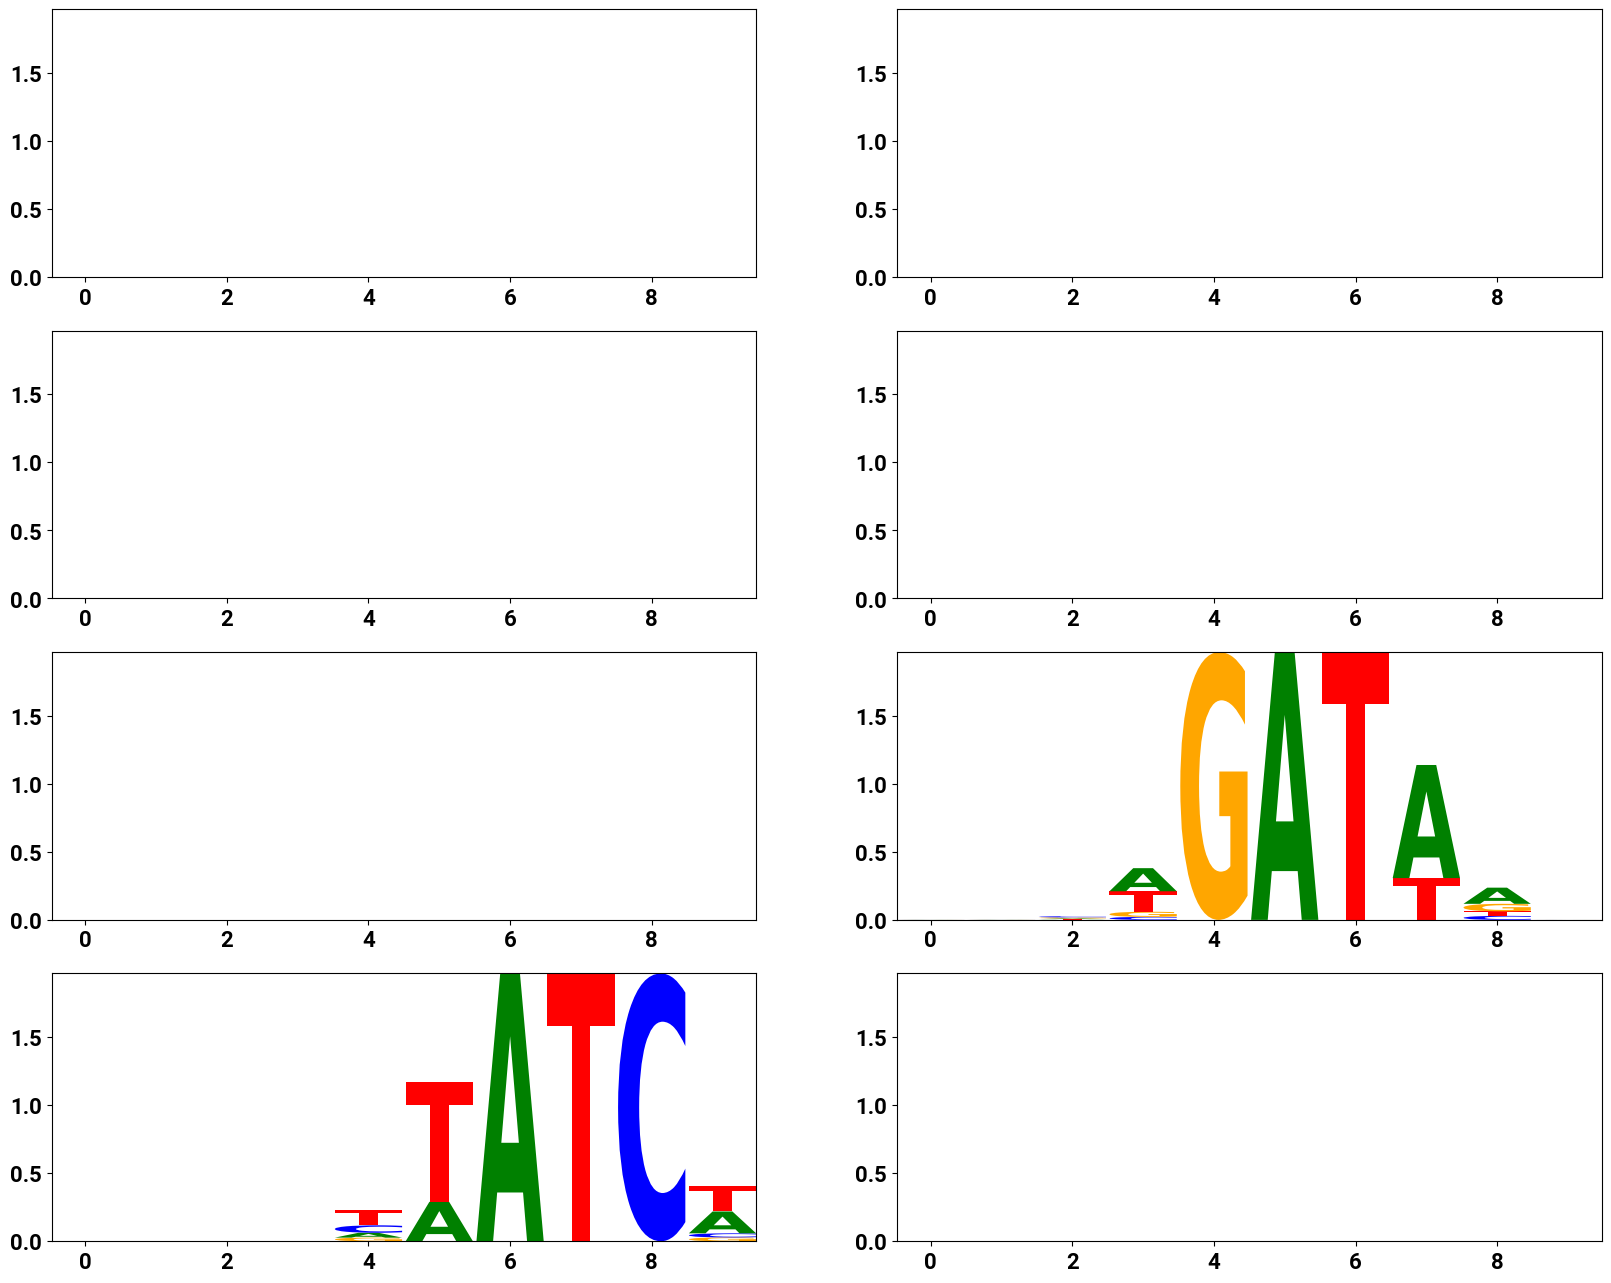

Intepretability score: 5.22


/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
	Loss: 0.3517: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 14.05it/s]
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes

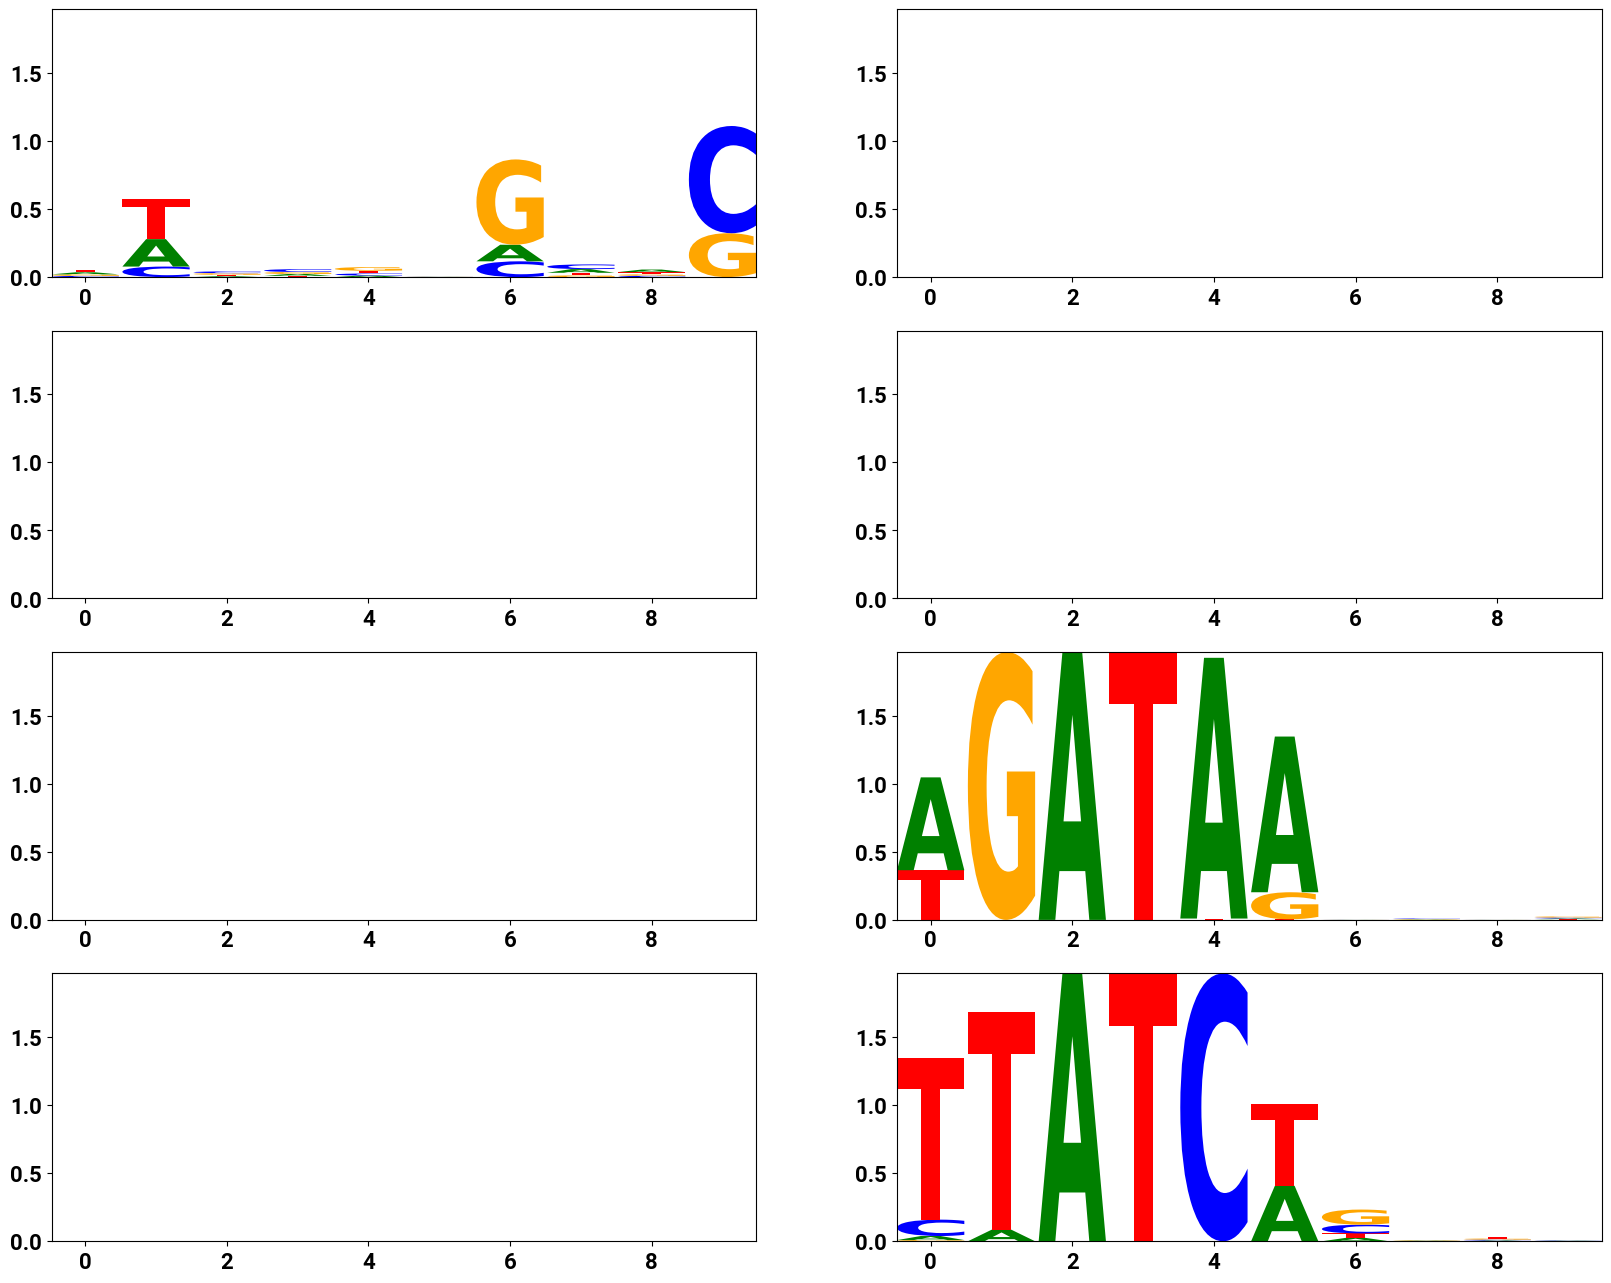

Intepretability score: 3.83


/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
	Loss: 0.3093: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12.12it/s]


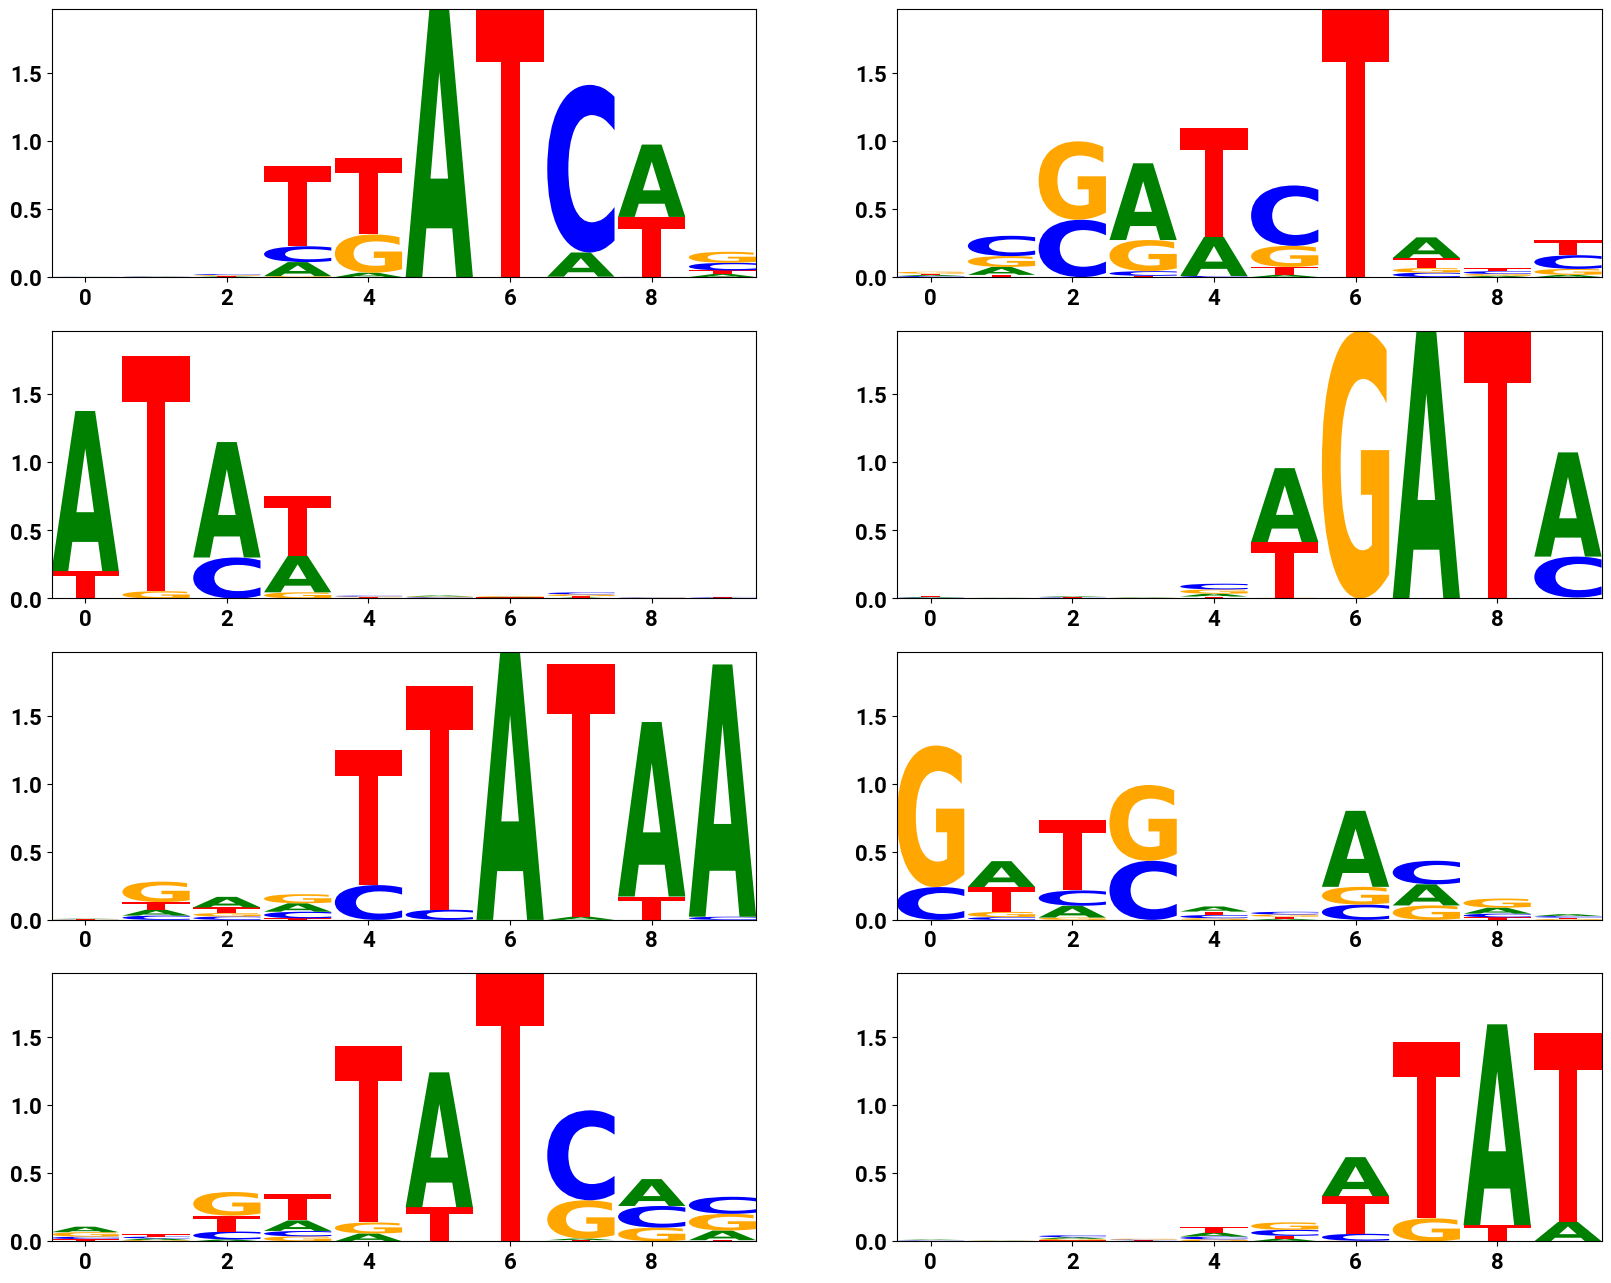

Intepretability score: 2.15


In [20]:
for model in (mechint_model, cnn_filteroverlap_model, cnn_actsparse_model):
    pfms = model_to_pfms(model, test_loader)
    plot_motifs.plot_motif_grid([pfm * motif_util.pfm_info_content(pfm)[:, None] for pfm in pfms])
    plt.show()

    passed_pfms = {i : pfm for i, pfm in enumerate(pfms) if np.sum(pfm) > 0}
    tomtom_hits = motif_compare.run_tomtom(
        passed_pfms, true_pfms
    )
    qvals = {i : (np.min(tomtom_hits[i]["q-value"]) if i in tomtom_hits else 1) for i in passed_pfms.keys()}
    score = np.mean(-np.log10(np.array(list(qvals.values()))))

    print("Intepretability score: %.2f" % score)